## Housing Price Prediction - Assignment Solution

Problem Statement : The company is looking at prospective properties to buy to enter the market.

You are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.
The company wants to know:
Which variables are significant in predicting the price of a house, and

How well those variables describe the price of a house.

The solution is divided into the following sections: 
- Data understanding
- Data cleaning
- Data Exploration
- Data preparation
- Model building and evaluation


In [99]:
#imprting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

import os

# hide warnings
import warnings
warnings.filterwarnings('ignore')

### 1. Data Understanding

Let's first have a look at the dataset and understand the size, attribute names etc.

In [100]:
# reading the dataset
housing = pd.read_csv("train.csv")

In [101]:
# summary of the dataset: 1460 rows, 81 columns
print(housing.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [102]:
# data understanding
# head
housing.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [103]:
# number of observations: 1460
housing.shape

(1460, 81)

#### Understanding the Data Dictionary

The data dictionary contains the meaning of various attributes; some non-obvious ones are:

In [104]:
housing['MSSubClass'].value_counts()

20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

In [105]:
housing['OverallCond'].value_counts()

5    821
6    252
7    205
8     72
4     57
3     25
9     22
2      5
1      1
Name: OverallCond, dtype: int64

In [106]:
housing['YrSold'].value_counts()

2009    338
2007    329
2006    314
2008    304
2010    175
Name: YrSold, dtype: int64

In [107]:
housing['MoSold'].value_counts()

6     253
7     234
5     204
4     141
8     122
3     106
10     89
11     79
9      63
12     59
1      58
2      52
Name: MoSold, dtype: int64

In [108]:
#MSSubClass, OverallCond,YrSold,MoSold are categorical but given it as integer so lets change it
housing['MSSubClass'] = housing['MSSubClass'].astype('category')
housing['OverallCond'] = housing['OverallCond'].astype('category')
housing['YrSold'] = housing['YrSold'].astype('category')
housing['MoSold'] = housing['MoSold'].astype('category')

Understand the Target Variable SalePrice

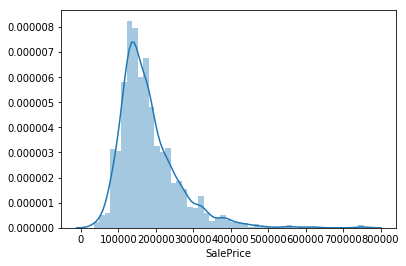

In [109]:
# target variable: saleprice of house
sns.distplot(housing['SalePrice'])
plt.show()

Sale Price range between 5lac to 40L dollars

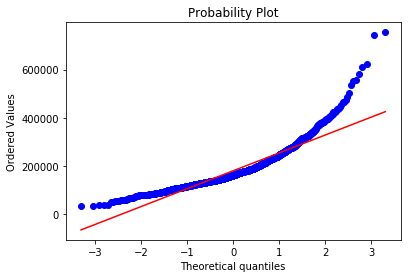

In [110]:
#plot a probability plot to check linear models expected to be normally distributed

fig = plt.figure()
res = stats.probplot(housing['SalePrice'], plot=plt)
plt.show()

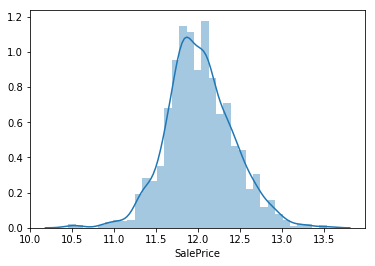

In [111]:
#Not normally distrbuted as price is in high numbers so lets do a Log Transformation
sns.distplot(housing['SalePrice'].apply(np.log))

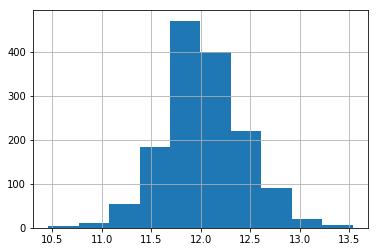

In [112]:
housing['SalePrice'].apply(np.log).hist()

Sale Price seems to be distrbuted normally on logarithmic scale

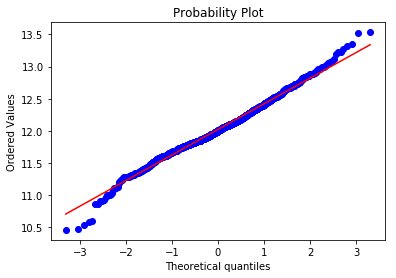

In [113]:
#plot again probability plot
fig = plt.figure()
res = stats.probplot(housing['SalePrice'].apply(np.log), plot=plt)
plt.show()

After Log transofrmation distribution of saleprice seems linear

### 2. Data Cleaning

check for missing data and handle it

In [114]:
#null data percentage

df_null = round(100*(housing.isnull().sum()/len(housing.index)), 2)
df_null.sort_values(ascending=False)

PoolQC           99.52
MiscFeature      96.30
Alley            93.77
Fence            80.75
FireplaceQu      47.26
LotFrontage      17.74
GarageCond        5.55
GarageType        5.55
GarageYrBlt       5.55
GarageFinish      5.55
GarageQual        5.55
BsmtExposure      2.60
BsmtFinType2      2.60
BsmtFinType1      2.53
BsmtCond          2.53
BsmtQual          2.53
MasVnrArea        0.55
MasVnrType        0.55
Electrical        0.07
Utilities         0.00
YearRemodAdd      0.00
MSSubClass        0.00
Foundation        0.00
ExterCond         0.00
ExterQual         0.00
Exterior2nd       0.00
Exterior1st       0.00
RoofMatl          0.00
RoofStyle         0.00
YearBuilt         0.00
                 ...  
GarageArea        0.00
PavedDrive        0.00
WoodDeckSF        0.00
OpenPorchSF       0.00
3SsnPorch         0.00
BsmtUnfSF         0.00
ScreenPorch       0.00
PoolArea          0.00
MiscVal           0.00
MoSold            0.00
YrSold            0.00
SaleType          0.00
Functional 

In [115]:
#drop the column having missing data more than 80%
housing = housing.drop(['PoolQC','MiscFeature','Alley','Fence'],1)

#### Lets analyse the missing percentage variables one by and one

In [116]:
#FirePlaceQu NA means no fireplace so lets put it as None
housing["FireplaceQu"] = housing["FireplaceQu"].fillna("None")

In [117]:
housing['LotFrontage'].describe()

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

In [118]:
#as mostly neighbourhood have same lot frontage so lets fill NA with median lotfrontage of neighbourhood
housing["LotFrontage"] = housing.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [119]:
#check again the missing percentage
df_null = round(100*(housing.isnull().sum()/len(housing.index)), 2)
df_null.sort_values(ascending=False)

GarageType       5.55
GarageYrBlt      5.55
GarageFinish     5.55
GarageCond       5.55
GarageQual       5.55
BsmtExposure     2.60
BsmtFinType2     2.60
BsmtFinType1     2.53
BsmtCond         2.53
BsmtQual         2.53
MasVnrType       0.55
MasVnrArea       0.55
Electrical       0.07
RoofMatl         0.00
RoofStyle        0.00
SalePrice        0.00
Exterior1st      0.00
Exterior2nd      0.00
YearBuilt        0.00
ExterQual        0.00
ExterCond        0.00
Foundation       0.00
YearRemodAdd     0.00
BldgType         0.00
OverallCond      0.00
LandContour      0.00
MSSubClass       0.00
MSZoning         0.00
LotFrontage      0.00
LotArea          0.00
                 ... 
PavedDrive       0.00
WoodDeckSF       0.00
OpenPorchSF      0.00
3SsnPorch        0.00
Functional       0.00
ScreenPorch      0.00
PoolArea         0.00
MiscVal          0.00
MoSold           0.00
YrSold           0.00
SaleType         0.00
Fireplaces       0.00
TotRmsAbvGrd     0.00
BsmtUnfSF        0.00
LowQualFin

In [120]:
housing['GarageCond'].value_counts()

TA    1326
Fa      35
Gd       9
Po       7
Ex       2
Name: GarageCond, dtype: int64

In [121]:
#As NA means no garage so lets replace with None same for all garage related categroical features 
#and integer 0 for GarageYrBlt,GarageArea,GarageCars

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    housing[col] = housing[col].fillna('None')

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    housing[col] = housing[col].fillna(0)

In [122]:
housing['BsmtExposure'].value_counts()

No    953
Av    221
Gd    134
Mn    114
Name: BsmtExposure, dtype: int64

In [123]:
# As there is no basement so lets put 0 for integer features and none for categorical features
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    housing[col] = housing[col].fillna('None')

In [124]:
#check againnull data percentage

df_null = round(100*(housing.isnull().sum()/len(housing.index)), 2)
df_null.sort_values(ascending=False)

MasVnrType       0.55
MasVnrArea       0.55
Electrical       0.07
SalePrice        0.00
Foundation       0.00
RoofMatl         0.00
Exterior1st      0.00
Exterior2nd      0.00
ExterQual        0.00
ExterCond        0.00
BsmtQual         0.00
YearRemodAdd     0.00
BsmtCond         0.00
BsmtExposure     0.00
BsmtFinType1     0.00
BsmtFinSF1       0.00
BsmtFinType2     0.00
BsmtFinSF2       0.00
RoofStyle        0.00
YearBuilt        0.00
TotalBsmtSF      0.00
Utilities        0.00
MSSubClass       0.00
MSZoning         0.00
LotFrontage      0.00
LotArea          0.00
Street           0.00
LotShape         0.00
LandContour      0.00
LotConfig        0.00
                 ... 
WoodDeckSF       0.00
OpenPorchSF      0.00
EnclosedPorch    0.00
3SsnPorch        0.00
ScreenPorch      0.00
PoolArea         0.00
MiscVal          0.00
MoSold           0.00
YrSold           0.00
SaleType         0.00
GarageFinish     0.00
GarageType       0.00
HeatingQC        0.00
FireplaceQu      0.00
CentralAir

No Missing Values

In [125]:
#Lets drop the rows as missing values are less then 2%
housing.dropna(inplace = True)

In [126]:
df_null = round(100*(housing.isnull().sum()/len(housing.index)), 2)
df_null.sort_values(ascending=False)

SalePrice        0.0
ExterCond        0.0
RoofStyle        0.0
RoofMatl         0.0
Exterior1st      0.0
Exterior2nd      0.0
MasVnrType       0.0
MasVnrArea       0.0
ExterQual        0.0
Foundation       0.0
TotalBsmtSF      0.0
BsmtQual         0.0
BsmtCond         0.0
BsmtExposure     0.0
BsmtFinType1     0.0
BsmtFinSF1       0.0
BsmtFinType2     0.0
BsmtFinSF2       0.0
YearRemodAdd     0.0
YearBuilt        0.0
OverallCond      0.0
OverallQual      0.0
MSSubClass       0.0
MSZoning         0.0
LotFrontage      0.0
LotArea          0.0
Street           0.0
LotShape         0.0
LandContour      0.0
Utilities        0.0
                ... 
WoodDeckSF       0.0
EnclosedPorch    0.0
HeatingQC        0.0
3SsnPorch        0.0
ScreenPorch      0.0
PoolArea         0.0
MiscVal          0.0
MoSold           0.0
YrSold           0.0
SaleType         0.0
GarageYrBlt      0.0
GarageType       0.0
FireplaceQu      0.0
Fireplaces       0.0
CentralAir       0.0
Electrical       0.0
1stFlrSF     

No Missing Values

In [127]:
housing.shape

(1451, 77)

So we dropped 4 columns and 9 rows

### 3. Data Exploration
Analyse the data using univariate and bivariate analysis

#### Visualising Categorical Variables

In [128]:
#filter out categorical variables from dataset
df_cat = housing.select_dtypes(include = ['object','category'])

In [129]:
df_cat.shape

(1451, 43)

44 columns and 1451 rows

Define function to boxplot

In [130]:
def plot_variable(col_name):
    plt.figure(figsize=(10,6))
    ax = sns.boxplot(x = col_name, y = 'SalePrice', data = housing)
    plt.title('% '+col_name)
    plt.xticks(rotation=90)
    plt.ylabel('SalePrice')

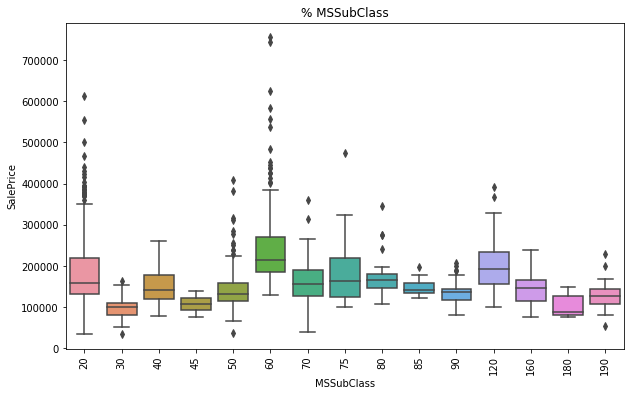

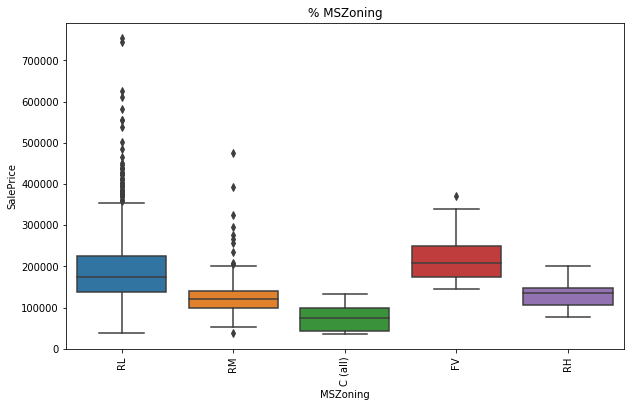

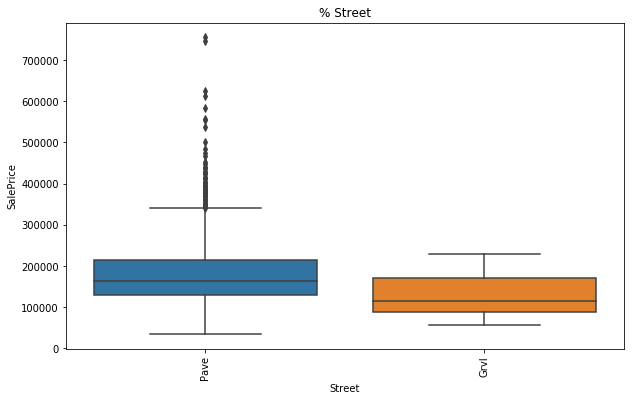

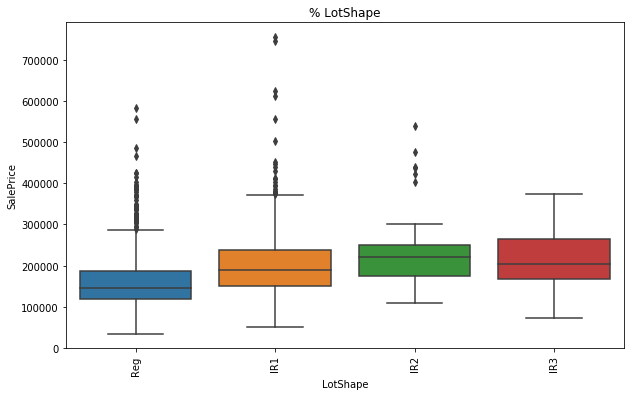

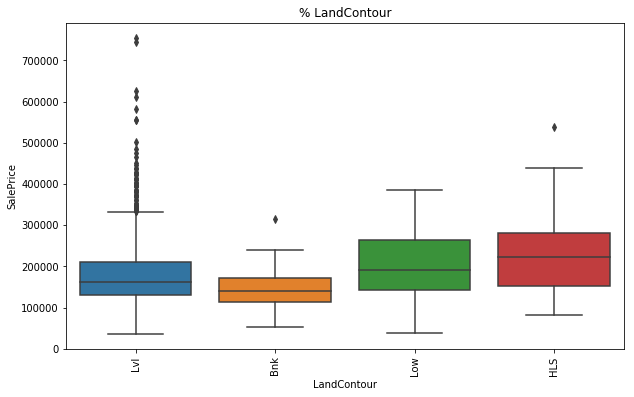

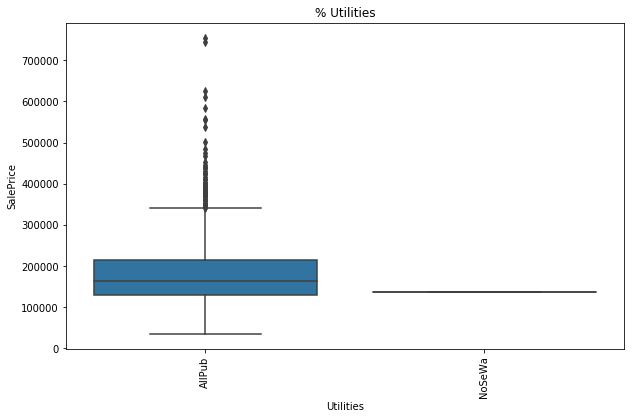

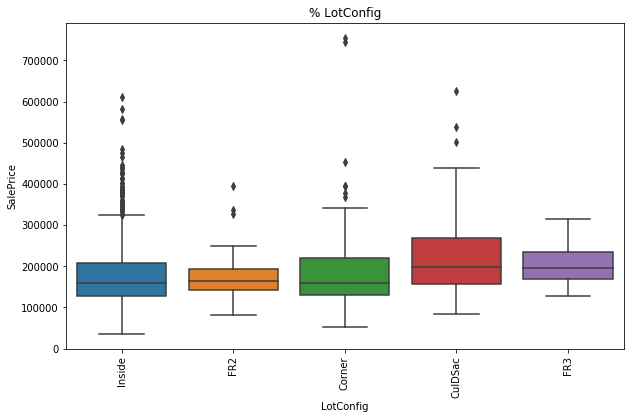

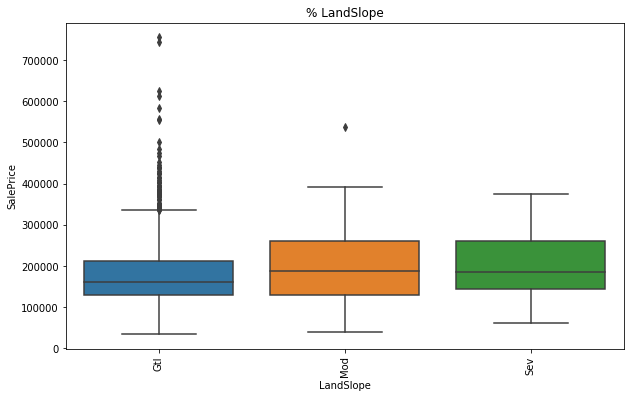

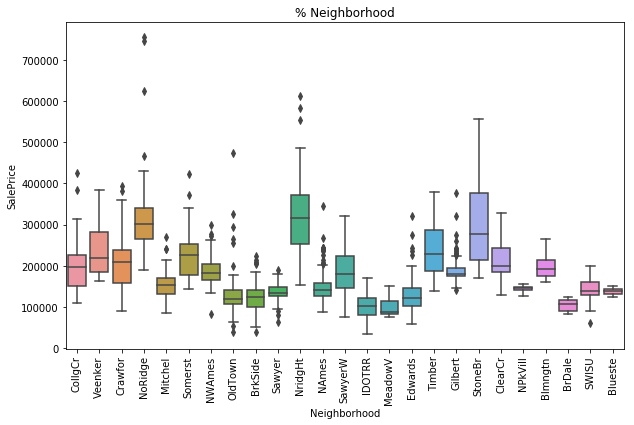

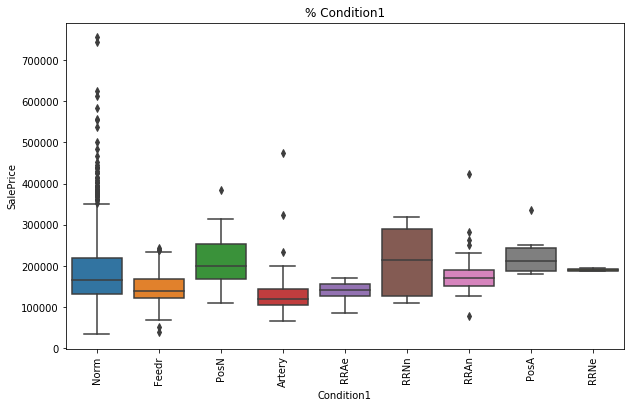

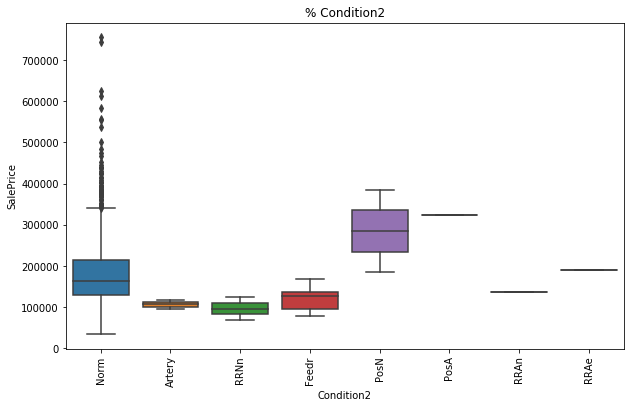

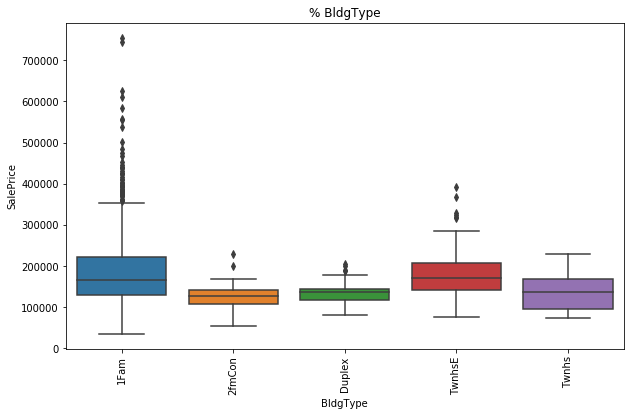

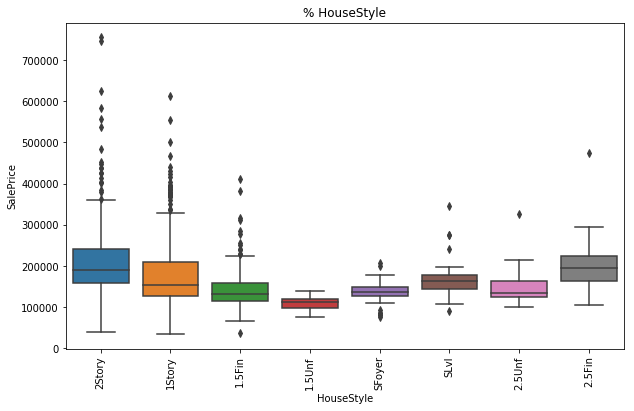

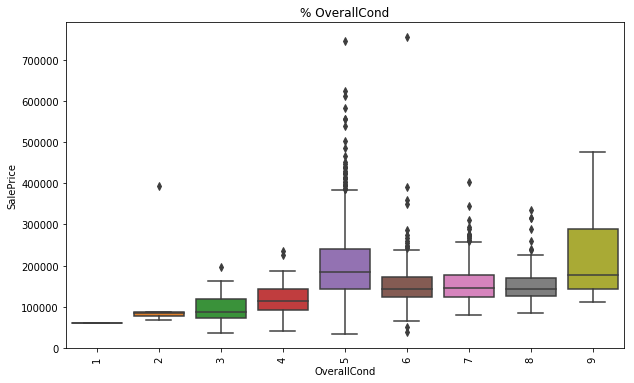

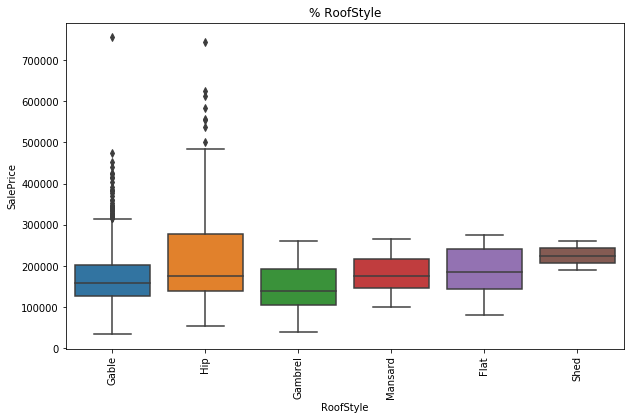

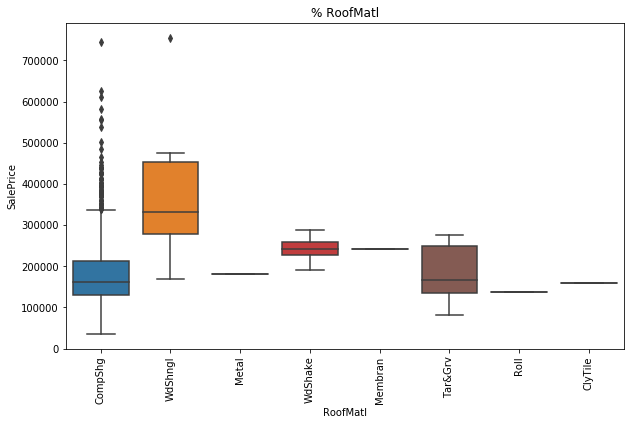

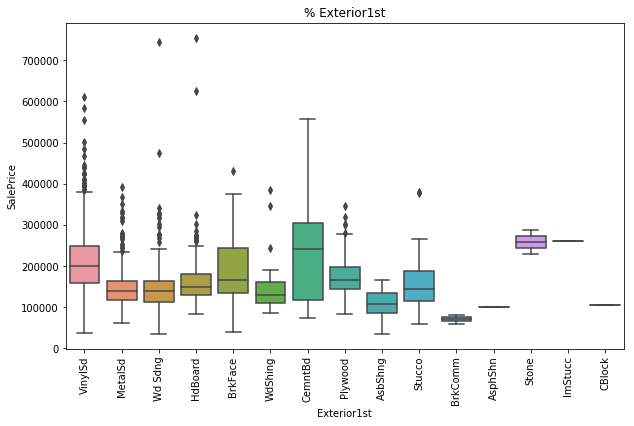

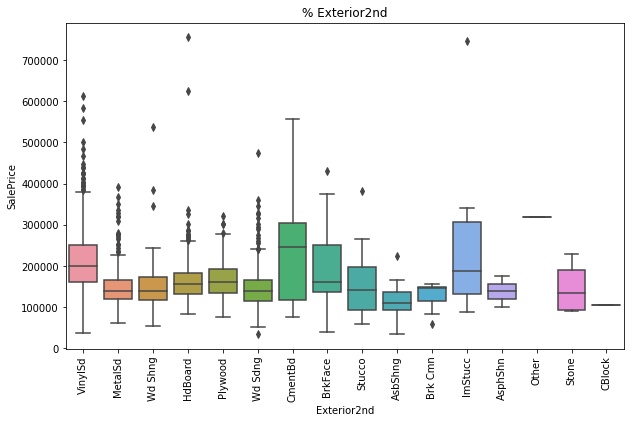

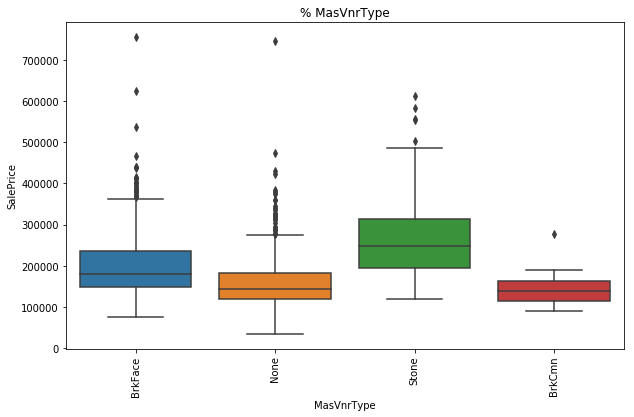

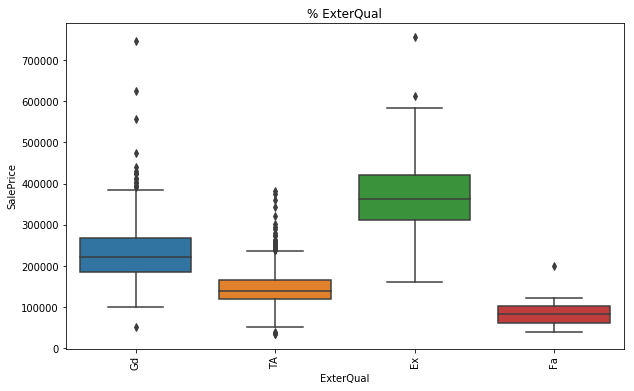

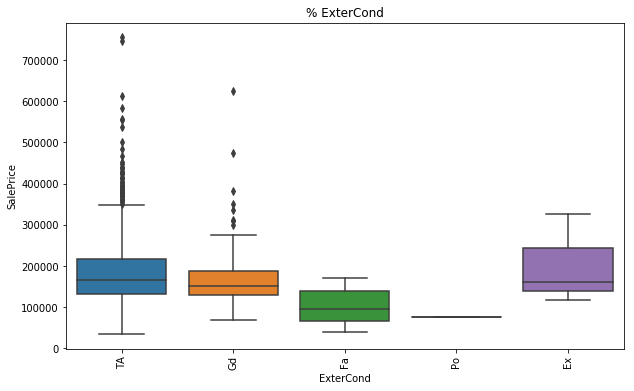

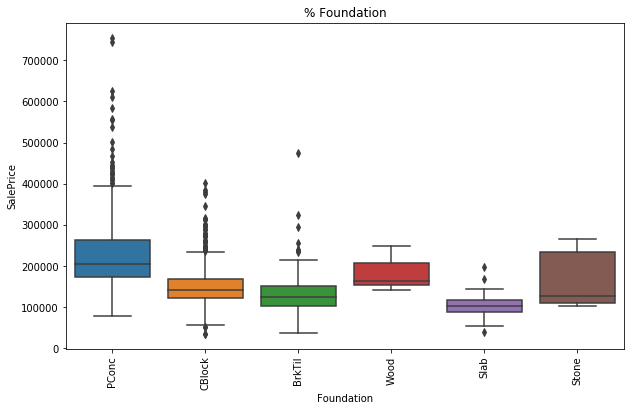

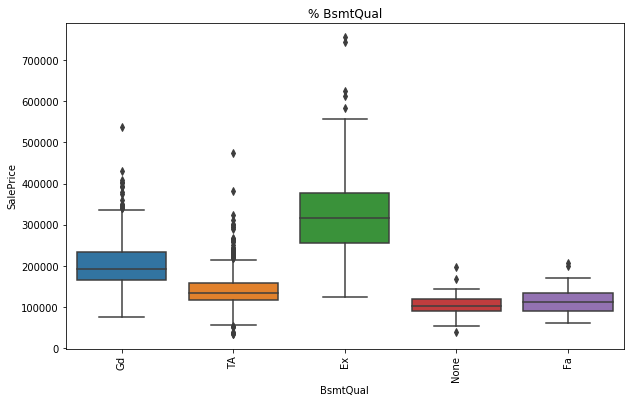

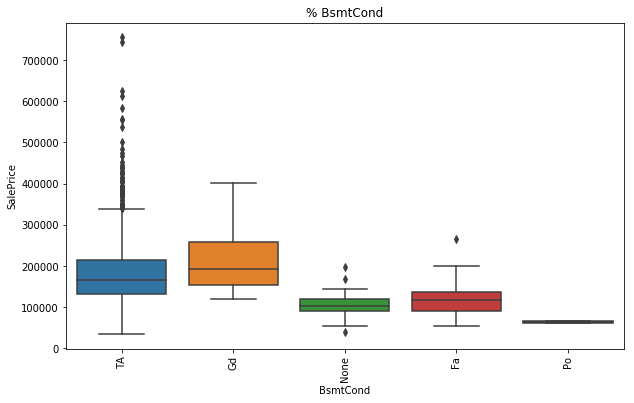

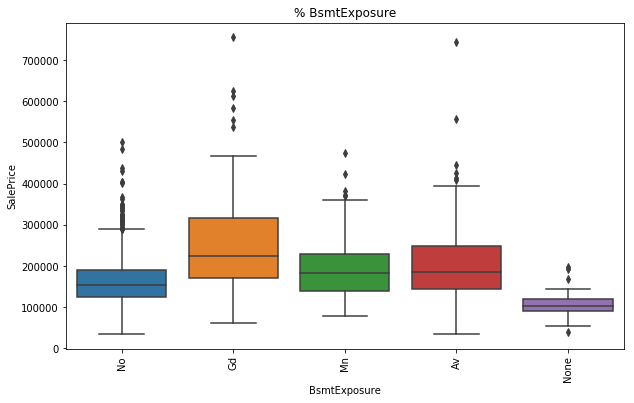

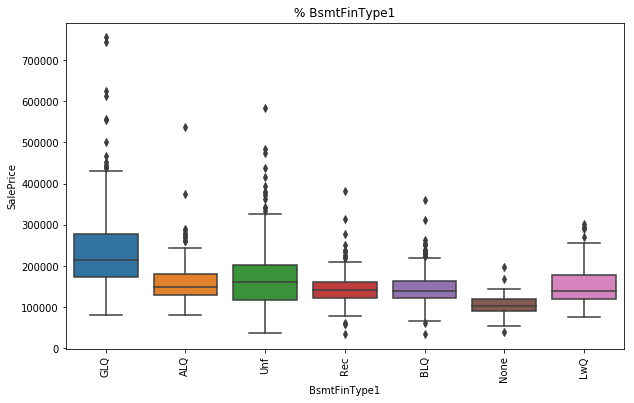

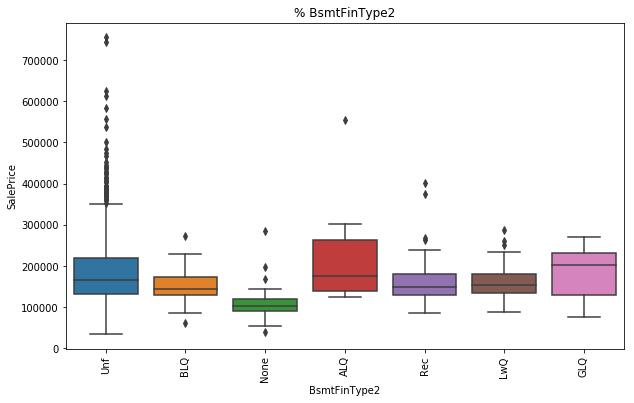

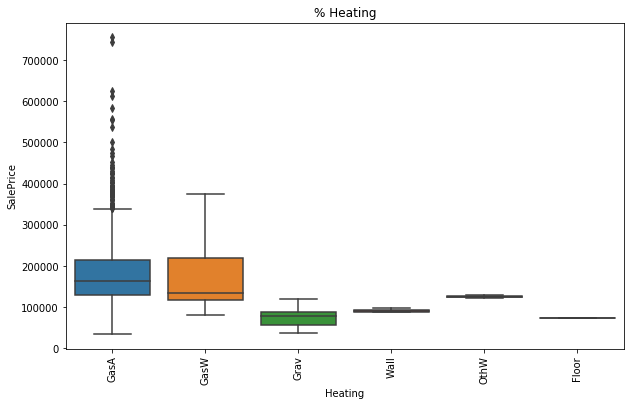

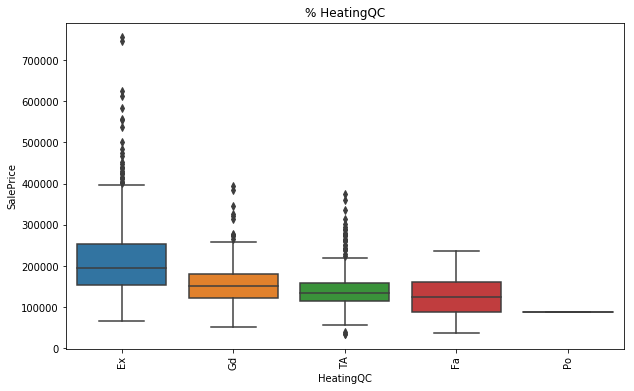

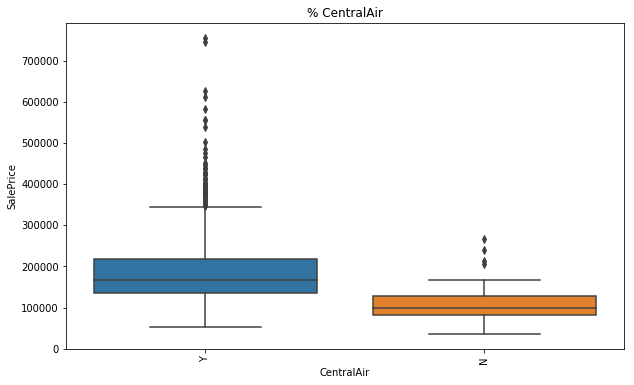

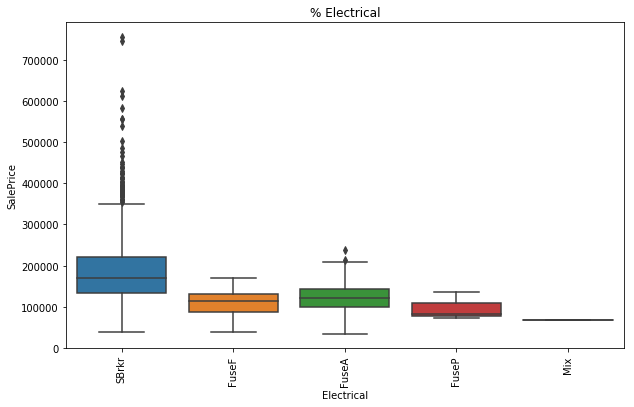

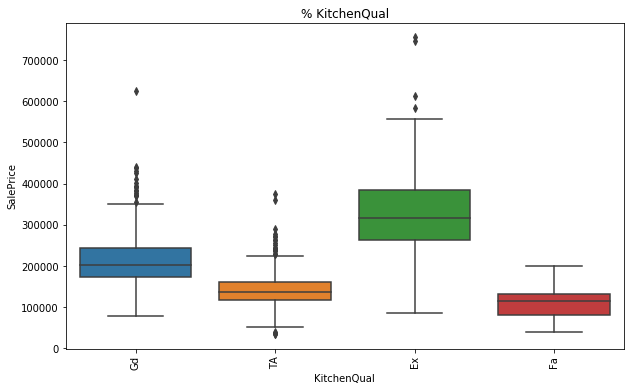

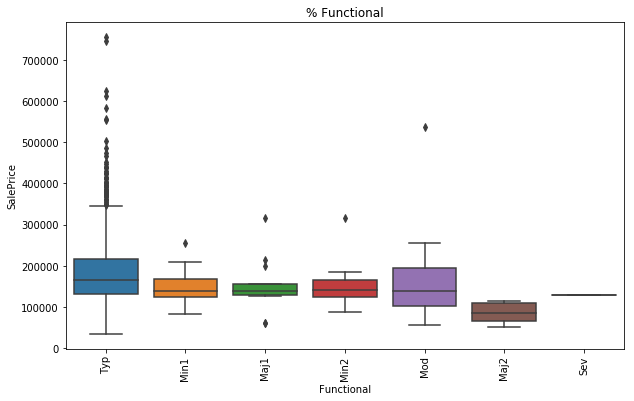

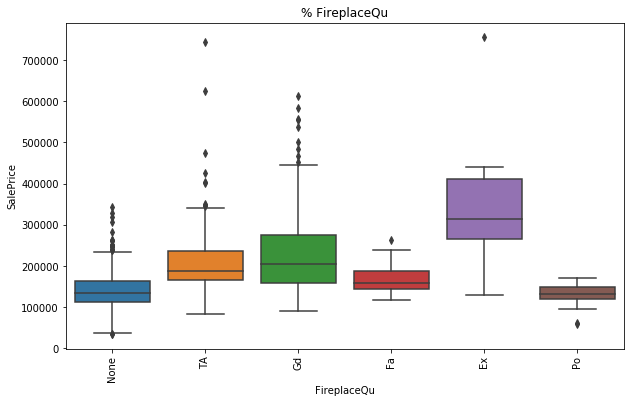

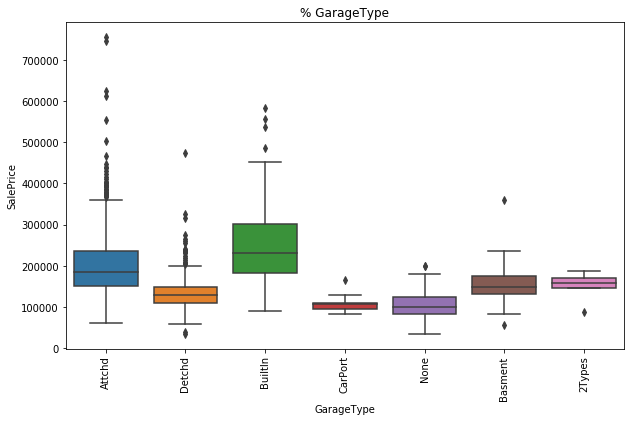

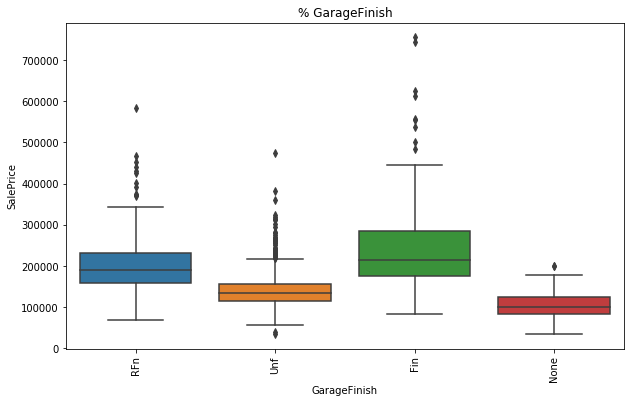

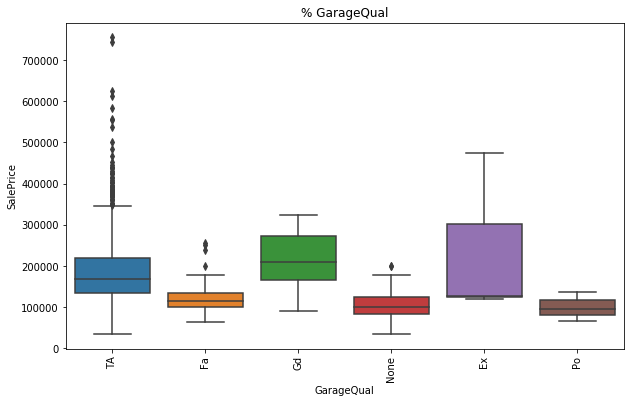

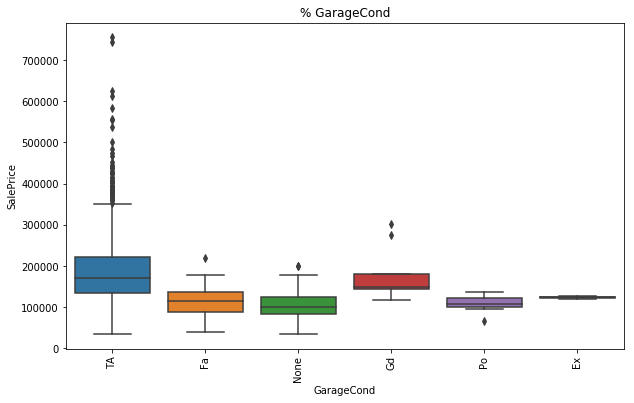

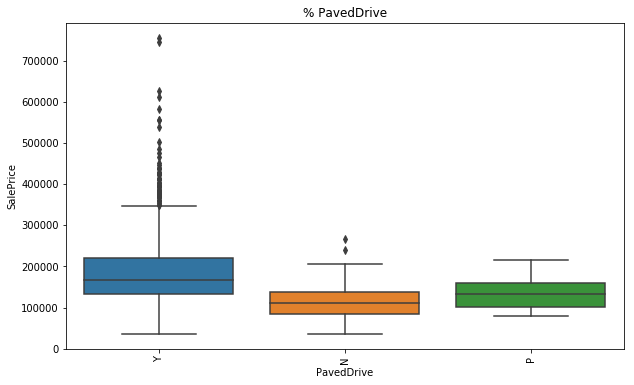

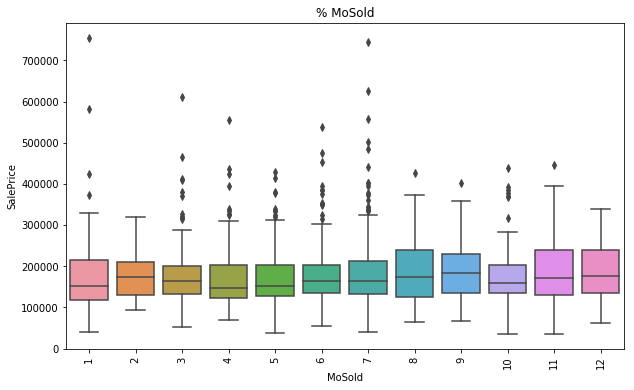

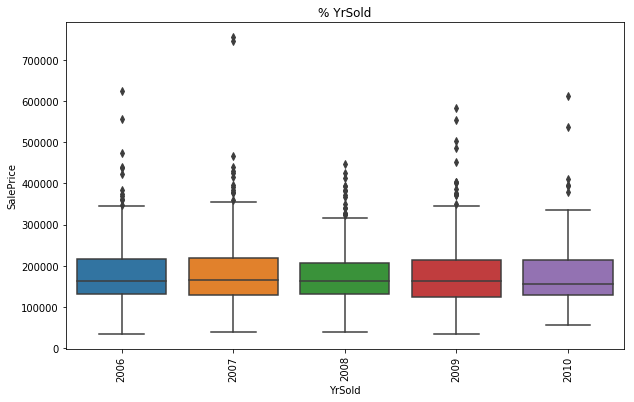

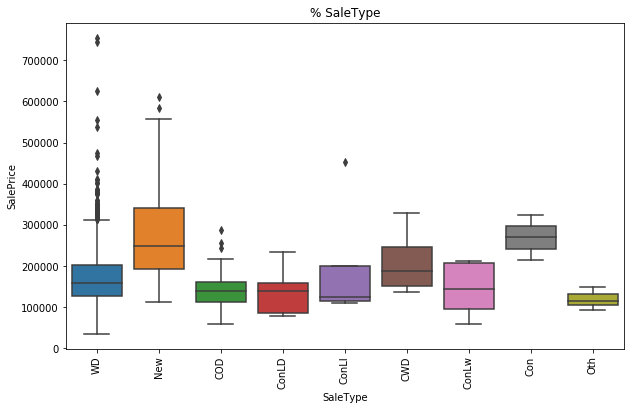

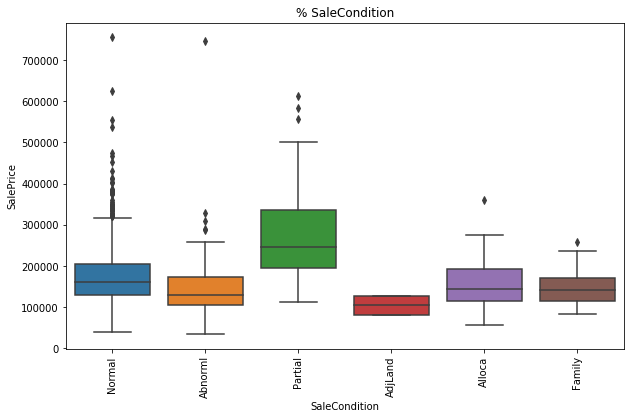

In [131]:
for c in df_cat.columns:
    plot_variable(c)

#### Inferences :

1. mszoning: FV houses have highest sale price followed by RL
2. street: PAve have more sale price then Grvl
3. utilities:All values have Allpub except 1 value so lets drop this column
4. Neighbourhood: Houses near StoneBr,NridGHT,NoRidge are costly areas
5. condition2: PosN condition houses sale price are more
6. RoofMatl: Wood Shingles materical houses sales price are more
7. ExtrQual : Houses having quality of the material on the exterior as excellent having sales price more then others.
8. BsmtQual : Excellent (100+ inches) height of the basement sales prcie are more then others. Also sale price decreasing with the height of basement this can be important factor, sale price highly depends on basement height
9. HeatingQC : SalePrice is also decreasing with heating quality so this feature has highly dependency on house sale price
10. CentralAir : This also seems important factor as centralized air is more preferable by majority of people so high sale price
11. KitchenQual: This is important part in the house so with decreasing quality price also decreasing. Important feature to consider
12. FireplaceQu: This also seems important feature as sales price of house decreasing with the fire place quality
13. Garage : This also seems important feature as sales price of house decreasing with the garage location,builtup and quality
14. Mosold : Every month approx similar value of sale price so we can drop this column
15. YrSold : Every year approx similar value of sale price so we can drop this column
16. SaleType : houses having 15% down payment sold on high price followed by newly constructed houses
17. SaleCondition : Partial condition houses sale price on higher side.

In [132]:
# drop the identified columns - utilities,MoSold,YrSold
df_cat= df_cat.drop(['Utilities','MoSold','YrSold'],1)

In [133]:
#RoofMatl maximum values is CompShg so lets drop this feature as no effect on SalePrice
#Heating maximum values is GasA so lets drop this feature as no effect on SalePrice
#Electrical maximum values is SBrkr so lets drop this feature as no effect on SalePrice
#Functional maximum values is Typ so lets drop this feature as no effect on SalePrice
#PavedDrive maximum values is Y so lets drop this feature as no effect on SalePrice

df_cat= df_cat.drop(['RoofMatl','Heating','Electrical','Functional','PavedDrive'],1)

#### Visualising Numerical Variables

In [134]:
#filter out only numeric columns
df_num = housing.select_dtypes(include = ['int64','float64'])

In [135]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1451 entries, 0 to 1459
Data columns (total 34 columns):
Id               1451 non-null int64
LotFrontage      1451 non-null float64
LotArea          1451 non-null int64
OverallQual      1451 non-null int64
YearBuilt        1451 non-null int64
YearRemodAdd     1451 non-null int64
MasVnrArea       1451 non-null float64
BsmtFinSF1       1451 non-null int64
BsmtFinSF2       1451 non-null int64
BsmtUnfSF        1451 non-null int64
TotalBsmtSF      1451 non-null int64
1stFlrSF         1451 non-null int64
2ndFlrSF         1451 non-null int64
LowQualFinSF     1451 non-null int64
GrLivArea        1451 non-null int64
BsmtFullBath     1451 non-null int64
BsmtHalfBath     1451 non-null int64
FullBath         1451 non-null int64
HalfBath         1451 non-null int64
BedroomAbvGr     1451 non-null int64
KitchenAbvGr     1451 non-null int64
TotRmsAbvGrd     1451 non-null int64
Fireplaces       1451 non-null int64
GarageYrBlt      1451 non-null float64

In [136]:
# Drop the id column as not relevant 
df_num = df_num.drop(['Id'],1)

In [137]:
df_num.shape

(1451, 33)

33 columns and 1451 rows

In [138]:
#Function to boxplot
def plot_num_variable(col_name):
    plt.figure(figsize=(10,6))
    ax = sns.boxplot(y=df_num_1[col_name])
    plt.title('% '+col_name)
    plt.xticks(rotation=90)

In [139]:
#copy the dataset before removing outliers
df_num_1=df_num

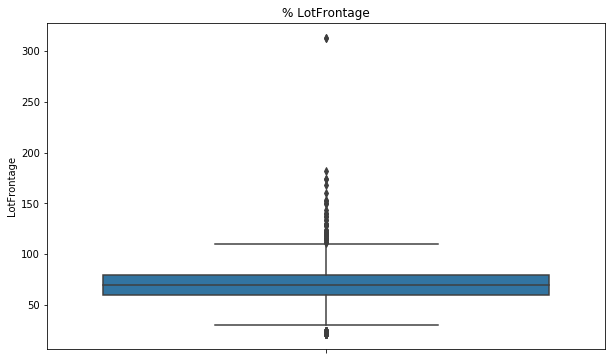

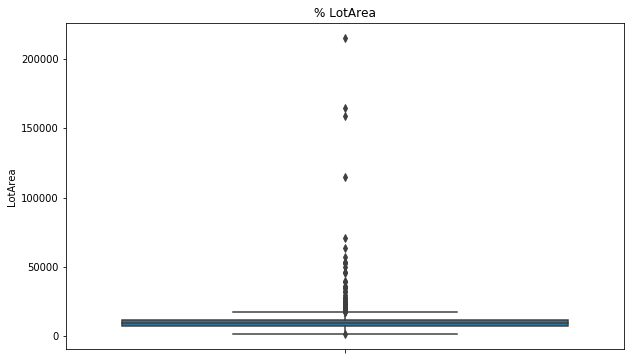

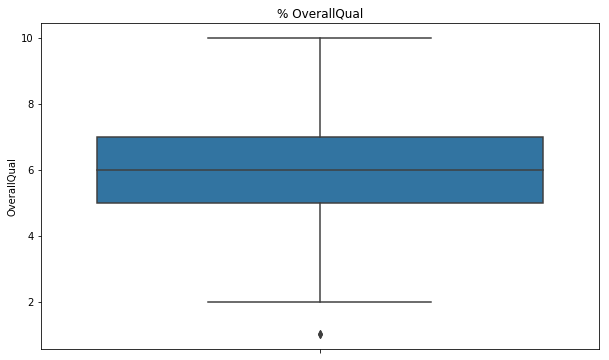

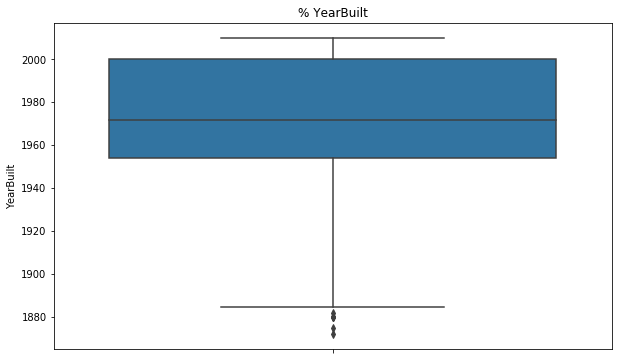

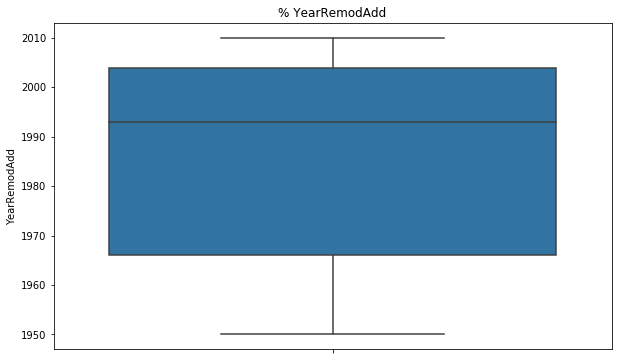

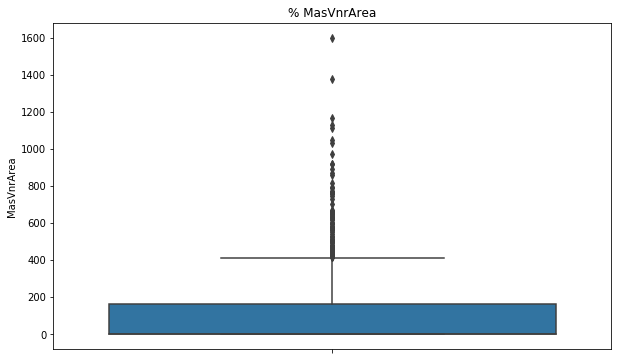

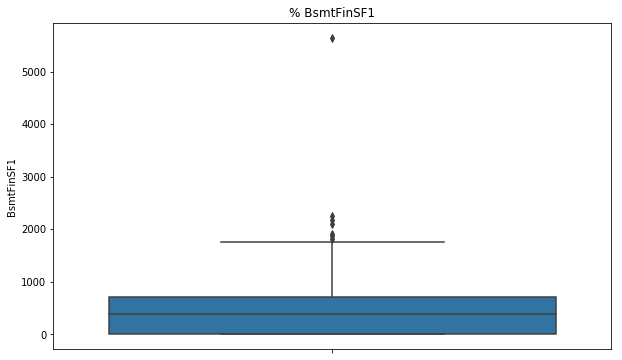

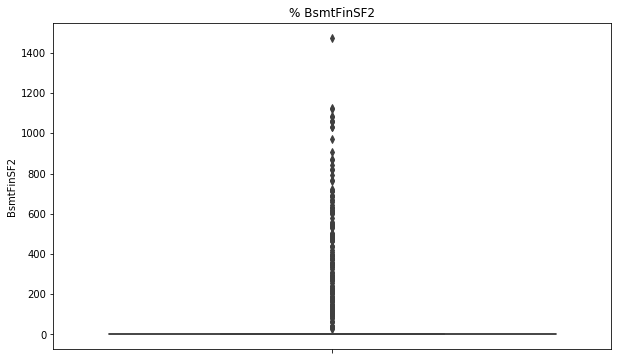

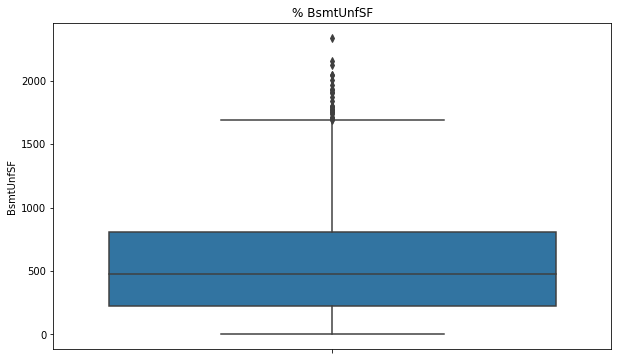

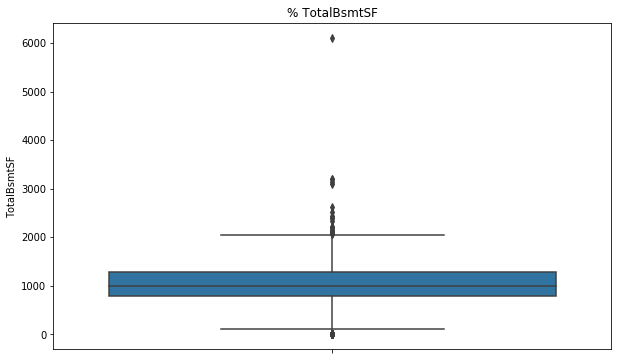

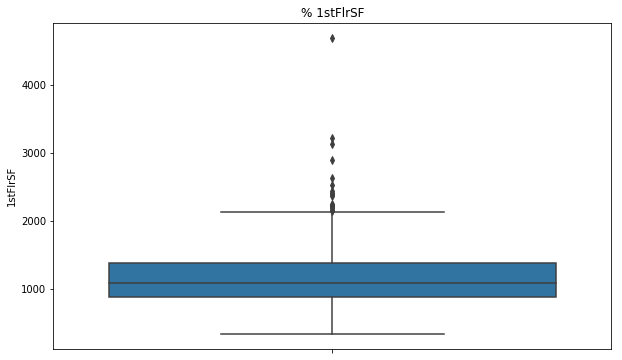

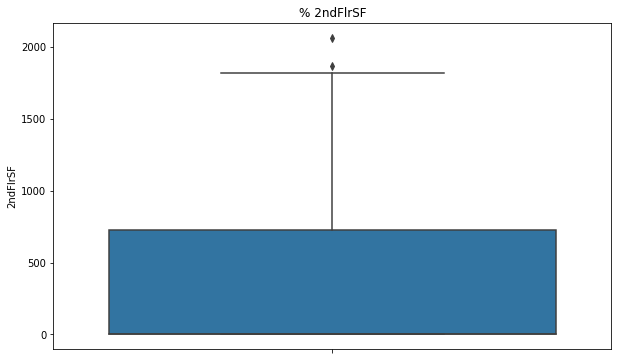

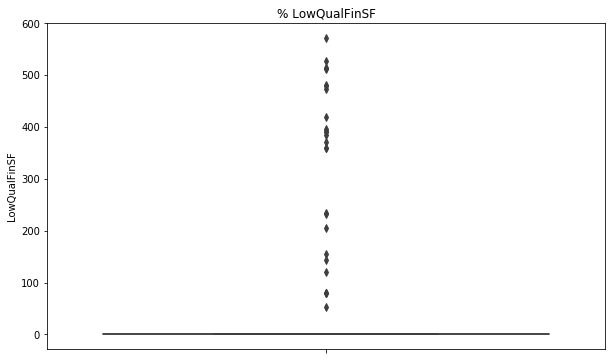

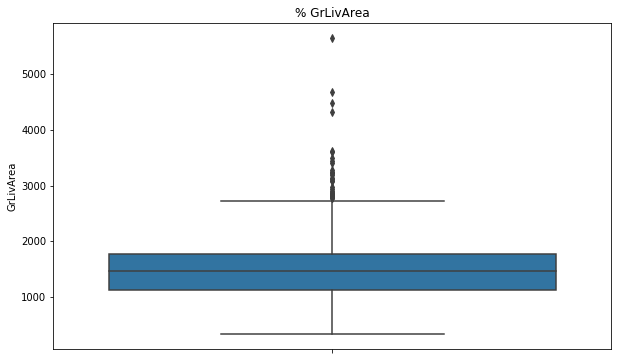

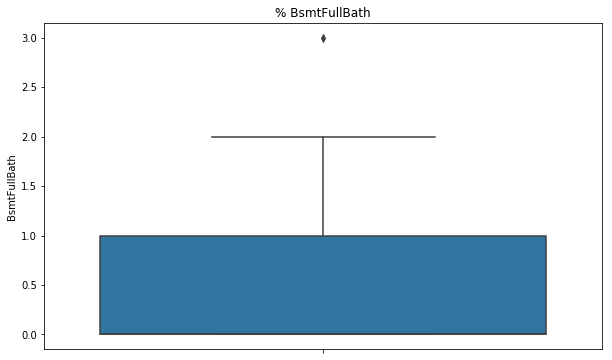

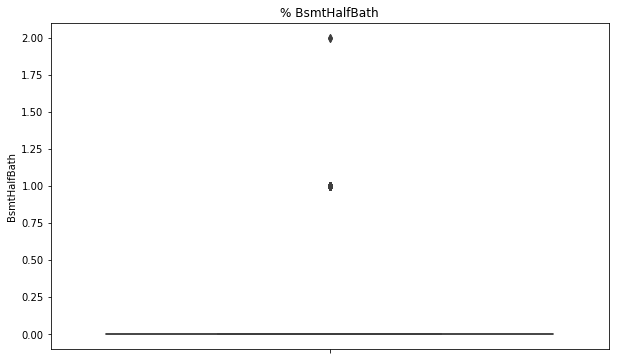

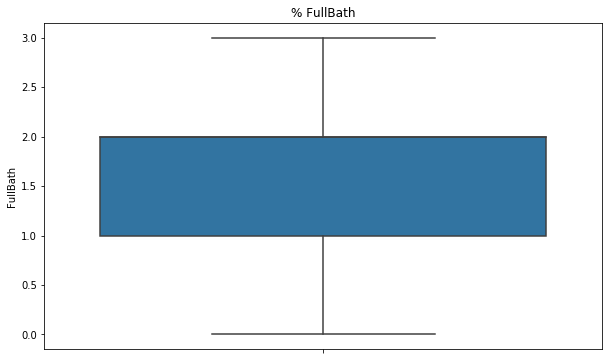

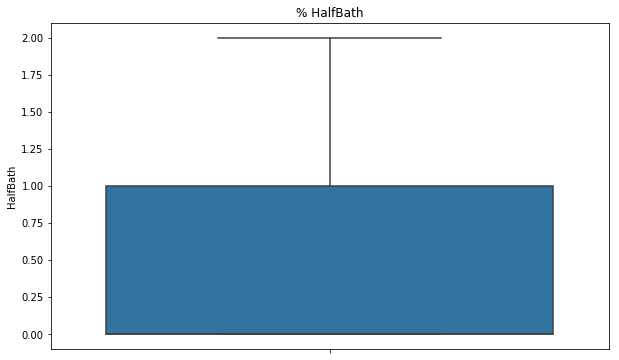

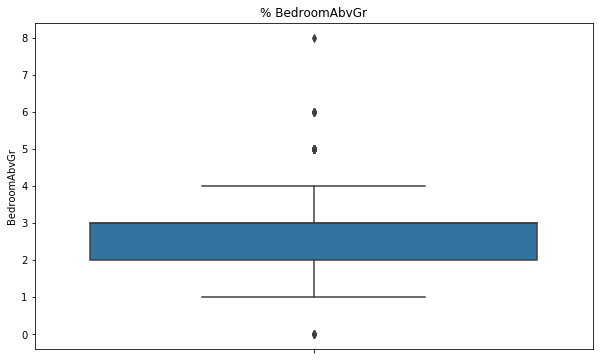

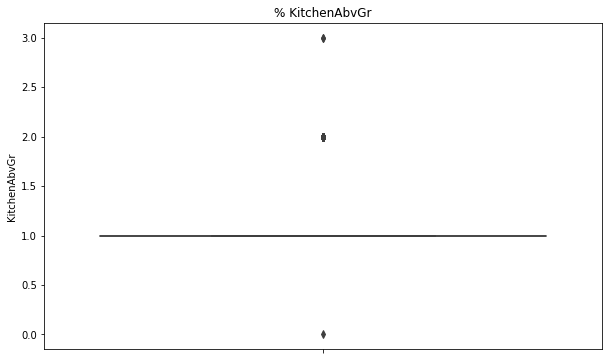

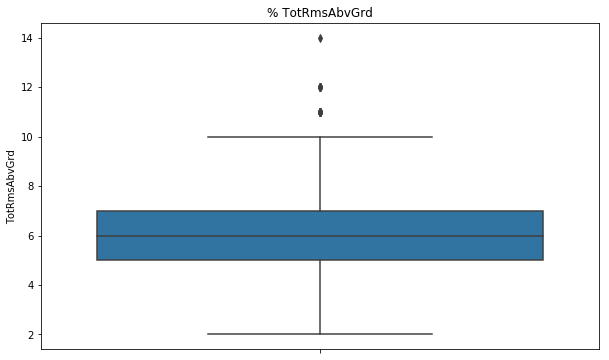

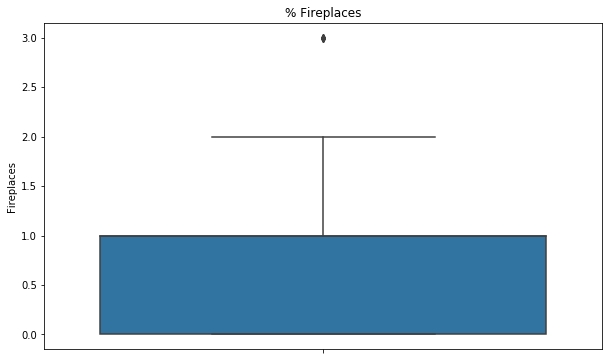

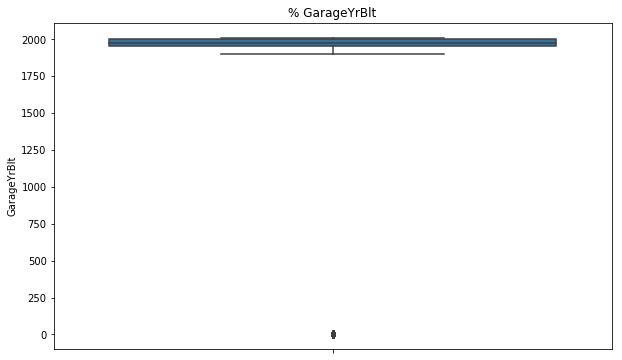

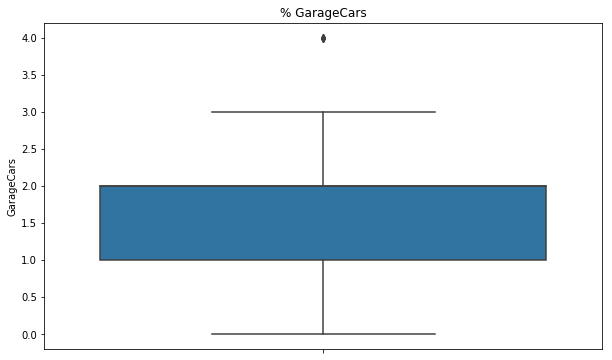

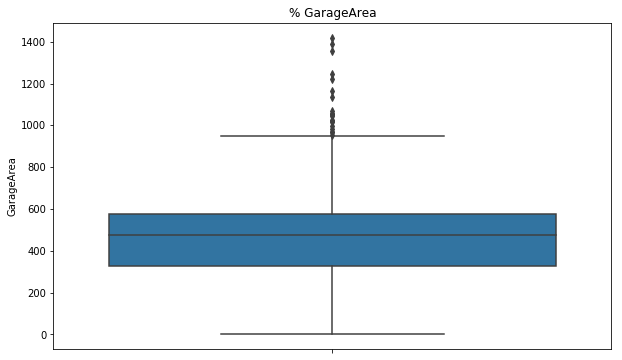

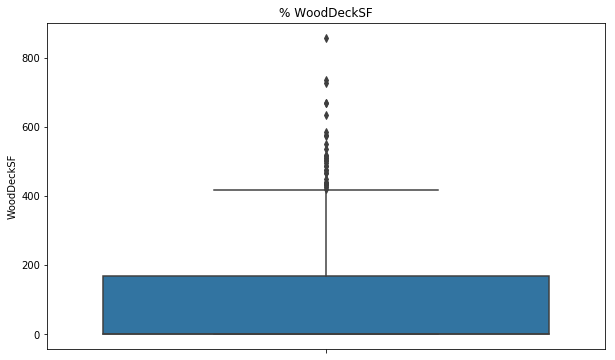

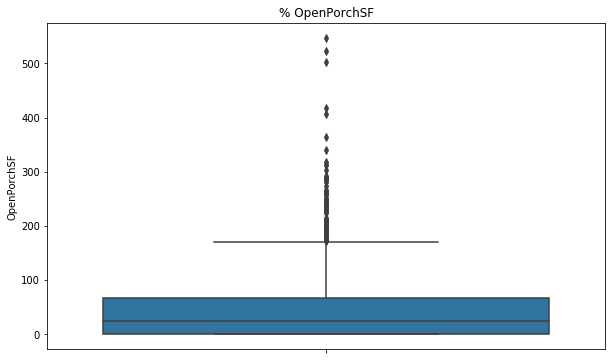

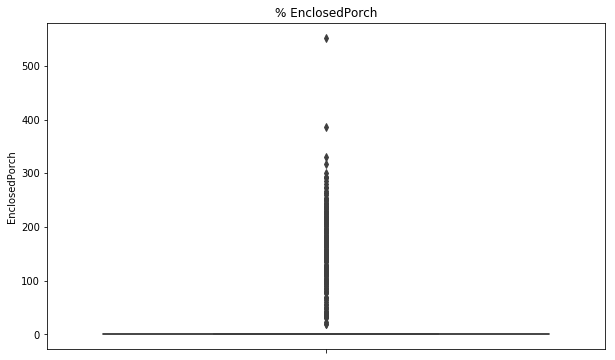

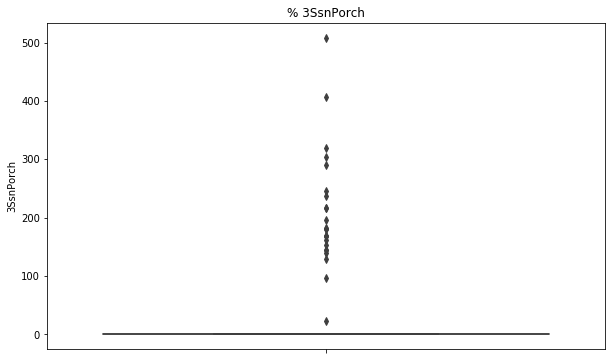

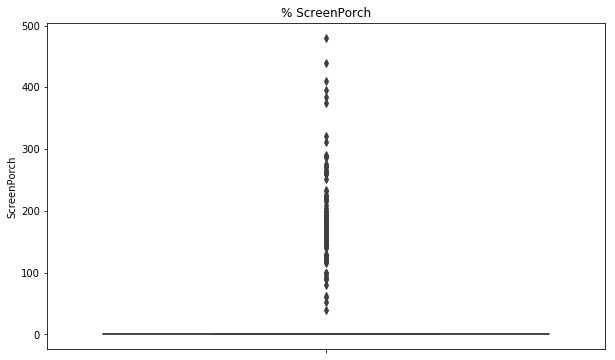

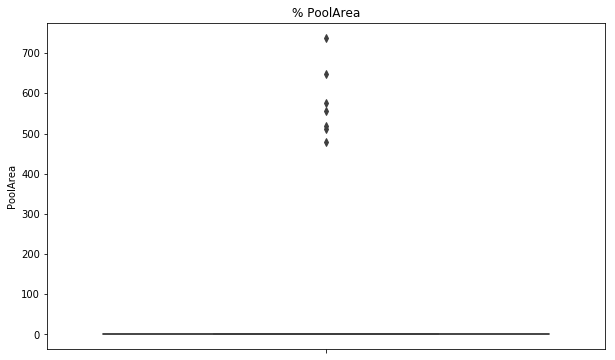

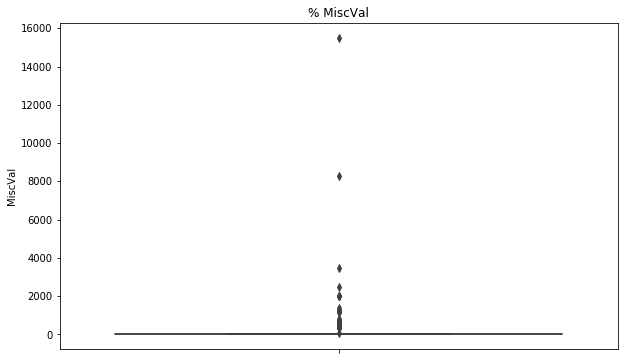

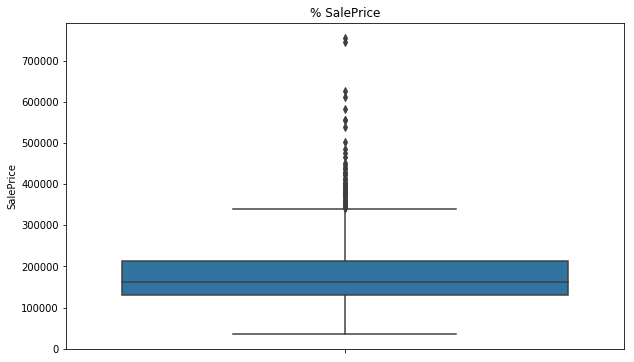

In [140]:
for c in df_num_1.columns:
    plot_num_variable(c)

In [141]:
# Let analyse the column having more outliers one by one

In [142]:
#BsmtHalfBath
df_num['BsmtHalfBath'].value_counts()

0    1369
1      80
2       2
Name: BsmtHalfBath, dtype: int64

In [143]:
#LowQualFinSF
df_num['LowQualFinSF'].value_counts()

0      1425
80        3
360       2
528       1
53        1
120       1
144       1
156       1
205       1
232       1
234       1
371       1
572       1
390       1
392       1
397       1
420       1
473       1
479       1
481       1
513       1
514       1
515       1
384       1
Name: LowQualFinSF, dtype: int64

In [144]:
#KitchenAbvGr
df_num['KitchenAbvGr'].value_counts()

1    1384
2      64
3       2
0       1
Name: KitchenAbvGr, dtype: int64

In [145]:
#GarageYrBlt
df_num['GarageYrBlt'].value_counts()

0.0       81
2005.0    65
2006.0    58
2004.0    53
2003.0    49
2007.0    45
1977.0    35
1998.0    31
1999.0    30
1976.0    29
2008.0    29
2000.0    27
1968.0    26
1950.0    24
2002.0    24
1993.0    22
1962.0    21
1966.0    21
2009.0    21
1965.0    21
1958.0    21
1970.0    20
1996.0    20
1957.0    20
2001.0    20
1997.0    19
1978.0    19
1960.0    19
1954.0    19
1964.0    18
          ..
1916.0     5
1922.0     5
1936.0     5
1928.0     4
1935.0     4
1945.0     4
1931.0     4
1946.0     4
1982.0     4
1923.0     3
1938.0     3
2010.0     3
1910.0     3
1924.0     3
1952.0     3
1932.0     3
1921.0     3
1947.0     2
1918.0     2
1929.0     2
1914.0     2
1915.0     2
1934.0     2
1937.0     2
1942.0     2
1906.0     1
1927.0     1
1900.0     1
1908.0     1
1933.0     1
Name: GarageYrBlt, Length: 98, dtype: int64

In [146]:
#EnclosedPorch
df_num['EnclosedPorch'].value_counts()

0      1244
112      15
96        6
120       5
144       5
192       5
216       5
252       4
116       4
156       4
102       3
228       3
176       3
184       3
150       3
40        3
164       3
128       3
126       3
32        2
180       2
264       2
185       2
158       2
190       2
80        2
154       2
202       2
205       2
244       2
       ... 
230       1
239       1
242       1
248       1
280       1
254       1
259       1
268       1
196       1
194       1
291       1
189       1
130       1
134       1
136       1
138       1
140       1
143       1
272       1
145       1
148       1
386       1
162       1
169       1
170       1
172       1
174       1
177       1
183       1
552       1
Name: EnclosedPorch, Length: 119, dtype: int64

In [147]:
#3SsnPorch
df_num['3SsnPorch'].value_counts()

0      1427
168       3
216       2
144       2
180       2
245       1
238       1
290       1
196       1
182       1
407       1
304       1
162       1
153       1
320       1
140       1
130       1
96        1
23        1
508       1
Name: 3SsnPorch, dtype: int64

In [148]:
#ScreenPorch
df_num['ScreenPorch'].value_counts()

0      1335
192       6
224       5
120       5
189       4
180       4
160       3
168       3
144       3
126       3
147       3
90        3
200       2
198       2
216       2
184       2
259       2
100       2
176       2
170       2
288       2
142       2
153       1
154       1
152       1
155       1
145       1
156       1
143       1
322       1
       ... 
163       1
165       1
291       1
287       1
276       1
273       1
271       1
266       1
265       1
263       1
260       1
252       1
234       1
233       1
225       1
374       1
222       1
220       1
210       1
204       1
197       1
385       1
190       1
396       1
185       1
182       1
440       1
178       1
312       1
480       1
Name: ScreenPorch, Length: 76, dtype: int64

In [149]:
# Drop the columns having only 1 value as this feature no effect on SalePrice
df_num = df_num.drop(['LowQualFinSF','KitchenAbvGr','3SsnPorch'],1)

Some features have outliers but we can leave them right now as it can be possible important information may lost during removal of outliers so take care of this in modeling

##### Data Correlation

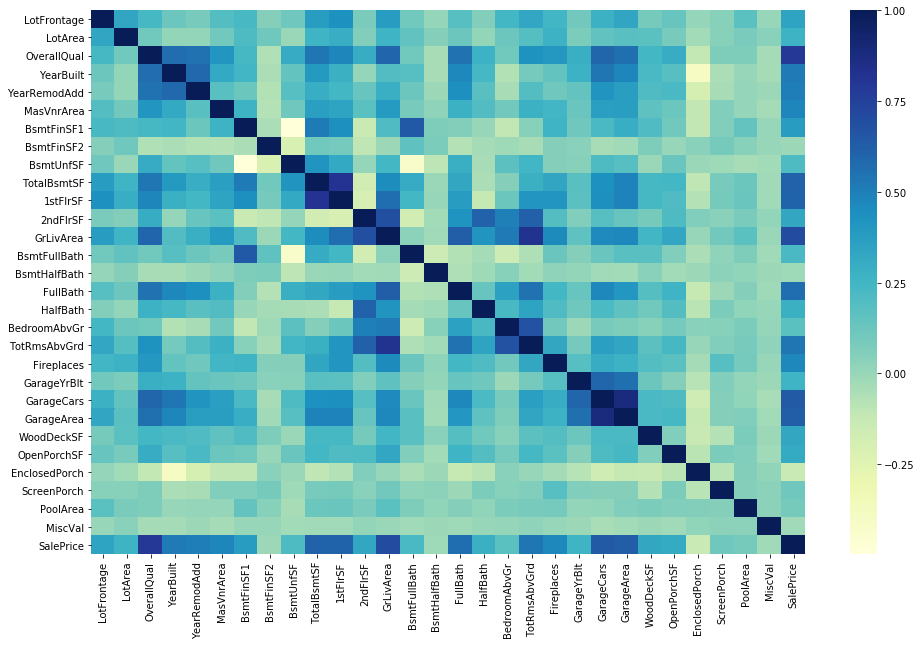

In [150]:
#Correlation map to see how features are correlated with SalePrice
plt.figure(figsize = (16, 10))
sns.heatmap(df_num.corr(), cmap="YlGnBu")
plt.show()

In [151]:
# check the correlation greater then >0.70

correlation_0 = df_num.corr().abs()
correlation_0 = correlation_0.unstack().sort_values(kind="quicksort")
correlation_0 = correlation_0.dropna()
correlation_0 = correlation_0[correlation_0 != 1.0]
corr = correlation_0[correlation_0 > 0.70]
print(round(corr,2))

GrLivArea     SalePrice       0.71
SalePrice     GrLivArea       0.71
OverallQual   SalePrice       0.79
SalePrice     OverallQual     0.79
1stFlrSF      TotalBsmtSF     0.82
TotalBsmtSF   1stFlrSF        0.82
TotRmsAbvGrd  GrLivArea       0.83
GrLivArea     TotRmsAbvGrd    0.83
GarageArea    GarageCars      0.88
GarageCars    GarageArea      0.88
dtype: float64


Sale Price is highly correlated with OverallQual,GrLiveArea

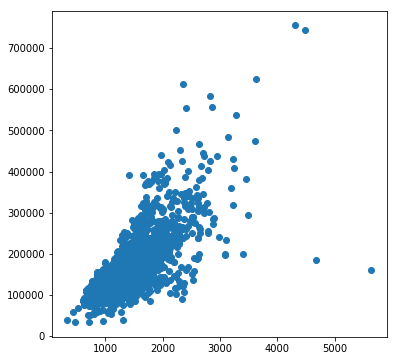

In [152]:
# plot SalePrice with GrLiveArea

plt.figure(figsize=[6,6])
plt.scatter(df_num['GrLivArea'], df_num['SalePrice'])
plt.show()

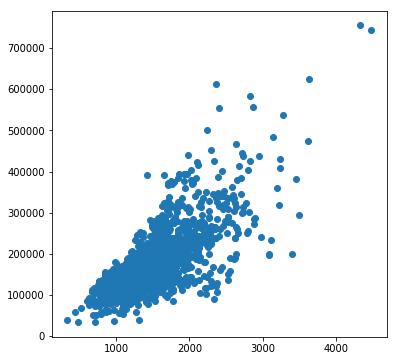

In [153]:
#Deleting outliers as this is highly dependent on SalePrice
df_num = df_num.drop(df_num[(df_num['GrLivArea']>4000) & (df_num['SalePrice']<300000)].index)

#plot it again
plt.figure(figsize=[6,6])
plt.scatter(df_num['GrLivArea'], df_num['SalePrice'])
plt.show()

In [154]:
# add two numeric and categorical variables again
df_eda = pd.concat([df_cat, df_num], axis=1)

In [155]:
#After concant chances to introduce missing data again so lets check it
df_null = round(100*(df_eda.isnull().sum()/len(df_eda.index)), 2)
df_null.sort_values(ascending=False)

SalePrice        0.14
BsmtFullBath     0.14
MiscVal          0.14
LotFrontage      0.14
LotArea          0.14
OverallQual      0.14
YearBuilt        0.14
YearRemodAdd     0.14
MasVnrArea       0.14
BsmtFinSF2       0.14
BsmtUnfSF        0.14
TotalBsmtSF      0.14
1stFlrSF         0.14
2ndFlrSF         0.14
GrLivArea        0.14
BsmtFinSF1       0.14
BsmtHalfBath     0.14
GarageCars       0.14
PoolArea         0.14
FullBath         0.14
ScreenPorch      0.14
EnclosedPorch    0.14
WoodDeckSF       0.14
GarageArea       0.14
OpenPorchSF      0.14
GarageYrBlt      0.14
Fireplaces       0.14
TotRmsAbvGrd     0.14
BedroomAbvGr     0.14
HalfBath         0.14
                 ... 
HouseStyle       0.00
BldgType         0.00
Condition2       0.00
Street           0.00
Neighborhood     0.00
LandSlope        0.00
LotConfig        0.00
LandContour      0.00
LotShape         0.00
MSZoning         0.00
ExterQual        0.00
MasVnrType       0.00
GarageCond       0.00
ExterCond        0.00
KitchenQua

In [156]:
#Lets drop the rows as missing values are less then 2%
df_eda.dropna(inplace = True)

In [157]:
# check it again
df_null = round(100*(df_eda.isnull().sum()/len(df_eda.index)), 2)
df_null.sort_values(ascending=False)

SalePrice        0.0
GarageQual       0.0
GarageType       0.0
FireplaceQu      0.0
KitchenQual      0.0
CentralAir       0.0
HeatingQC        0.0
BsmtFinType2     0.0
BsmtFinType1     0.0
BsmtExposure     0.0
BsmtCond         0.0
BsmtQual         0.0
Foundation       0.0
ExterCond        0.0
ExterQual        0.0
MasVnrType       0.0
Exterior2nd      0.0
Exterior1st      0.0
RoofStyle        0.0
OverallCond      0.0
HouseStyle       0.0
BldgType         0.0
Condition2       0.0
Condition1       0.0
Neighborhood     0.0
LandSlope        0.0
LotConfig        0.0
LandContour      0.0
LotShape         0.0
Street           0.0
                ... 
PoolArea         0.0
ScreenPorch      0.0
EnclosedPorch    0.0
OpenPorchSF      0.0
WoodDeckSF       0.0
GarageArea       0.0
GarageCars       0.0
GarageYrBlt      0.0
Fireplaces       0.0
TotRmsAbvGrd     0.0
BedroomAbvGr     0.0
HalfBath         0.0
FullBath         0.0
BsmtHalfBath     0.0
BsmtFullBath     0.0
GrLivArea        0.0
2ndFlrSF     

No Missing data

In [158]:
df_eda.shape

(1449, 65)

Final Dataset after EDA contains 66 columns and 1449 rows

### 4. Data Preparation

In [159]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1449 entries, 0 to 1459
Data columns (total 65 columns):
MSSubClass       1449 non-null category
MSZoning         1449 non-null object
Street           1449 non-null object
LotShape         1449 non-null object
LandContour      1449 non-null object
LotConfig        1449 non-null object
LandSlope        1449 non-null object
Neighborhood     1449 non-null object
Condition1       1449 non-null object
Condition2       1449 non-null object
BldgType         1449 non-null object
HouseStyle       1449 non-null object
OverallCond      1449 non-null category
RoofStyle        1449 non-null object
Exterior1st      1449 non-null object
Exterior2nd      1449 non-null object
MasVnrType       1449 non-null object
ExterQual        1449 non-null object
ExterCond        1449 non-null object
Foundation       1449 non-null object
BsmtQual         1449 non-null object
BsmtCond         1449 non-null object
BsmtExposure     1449 non-null object
BsmtFinType1   

Convert binary values to 0 and 1

In [160]:
varlist =  ['CentralAir']

# Defining the map function
def binary_map(x):
    return x.map({'Y': 1, "N": 0})

# Applying the function to the housing list
df_eda[varlist] = df_eda[varlist].apply(binary_map)

#### Apply LabelEncoder to categorical features having ordered values like Good,Excellent etc.

In [161]:
cols = ('OverallCond','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','KitchenQual','FireplaceQu',
        'GarageQual','GarageCond','HeatingQC','BsmtFinType1','BsmtFinType2','Street','MSSubClass')

for c in cols:
    label = LabelEncoder() 
    label.fit(list(df_eda[c].values)) 
    df_eda[c] = label.transform(list(df_eda[c].values))

In [162]:
df_eda.head()

,MSSubClass,MSZoning,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,PoolArea,MiscVal,SalePrice
0,5,RL,1,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,...,2003.0,2.0,548.0,0.0,61.0,0.0,0.0,0.0,0.0,208500.0
1,0,RL,1,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,...,1976.0,2.0,460.0,298.0,0.0,0.0,0.0,0.0,0.0,181500.0
2,5,RL,1,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,...,2001.0,2.0,608.0,0.0,42.0,0.0,0.0,0.0,0.0,223500.0
3,6,RL,1,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,...,1998.0,3.0,642.0,0.0,35.0,272.0,0.0,0.0,0.0,140000.0
4,5,RL,1,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,...,2000.0,3.0,836.0,192.0,84.0,0.0,0.0,0.0,0.0,250000.0


#### Dummy Variables for Categorical variables to convert into numeric for model

In [163]:
# Defining the map function
def dummies(x,df):
    temp = pd.get_dummies(df[x], drop_first = True)
    df = pd.concat([df, temp], axis = 1)
    df.drop([x], axis = 1, inplace = True)
    return df

# Applying the function to the df_eda

df_eda = dummies('MSZoning',df_eda)
df_eda = dummies('LotShape',df_eda)
df_eda = dummies('LandContour',df_eda)
df_eda = dummies('LotConfig',df_eda)
df_eda = dummies('LandSlope',df_eda)
df_eda = dummies('Neighborhood',df_eda)
df_eda = dummies('Condition1',df_eda)
df_eda = dummies('Condition2',df_eda)
df_eda = dummies('BldgType',df_eda)
df_eda = dummies('HouseStyle',df_eda)
df_eda = dummies('RoofStyle',df_eda)
df_eda = dummies('Exterior1st',df_eda)
df_eda = dummies('Exterior2nd',df_eda)
df_eda = dummies('MasVnrType',df_eda)
df_eda = dummies('Foundation',df_eda)
df_eda = dummies('GarageType',df_eda)
df_eda = dummies('GarageFinish',df_eda)
df_eda = dummies('SaleType',df_eda)
df_eda = dummies('SaleCondition',df_eda)

In [164]:
df_eda.shape

(1449, 176)

#### Lets get the variable having correlation with SalePrice less then 0.1

In [165]:
df_cor = np.abs(df_eda.corr()['SalePrice'])
cor_1=df_cor[df_cor<0.1].index
cor_1

Index(['MSSubClass', 'Street', 'OverallCond', 'BsmtCond', 'BsmtFinType1',
       'BsmtFinType2', 'FireplaceQu', 'BsmtFinSF2', 'BsmtHalfBath', 'MiscVal',
       'FV', 'RH', 'IR3', 'Low', 'Lvl', 'FR2', 'FR3', 'Inside', 'Mod', 'Sev',
       'Blueste', 'ClearCr', 'CollgCr', 'Crawfor', 'Gilbert', 'Mitchel',
       'NPkVill', 'NWAmes', 'SWISU', 'SawyerW', 'Veenker', 'PosA', 'PosN',
       'RRAe', 'RRAn', 'RRNe', 'RRNn', 'Feedr', 'Norm', 'PosA', 'PosN', 'RRAe',
       'RRAn', 'RRNn', '2fmCon', 'Twnhs', 'TwnhsE', '1.5Unf', '1Story',
       '2.5Fin', '2.5Unf', 'SFoyer', 'SLvl', 'Gambrel', 'Mansard', 'Shed',
       'AsphShn', 'BrkComm', 'BrkFace', 'CBlock', 'HdBoard', 'ImStucc',
       'Plywood', 'Stone', 'Stucco', 'WdShing', 'AsphShn', 'Brk Cmn',
       'BrkFace', 'CBlock', 'HdBoard', 'ImStucc', 'Other', 'Plywood', 'Stone',
       'Stucco', 'Wd Shng', 'Stone', 'Wood', 'Basment', 'CarPort', 'CWD',
       'Con', 'ConLD', 'ConLI', 'ConLw', 'Oth', 'AdjLand', 'Alloca', 'Family'],
      dtype='object

In [166]:
# Drop these features as not relevant on target variable
df_final=df_eda.drop(['MSSubClass', 'Street', 'OverallCond', 'BsmtCond', 'BsmtFinType1',
       'BsmtFinType2', 'FireplaceQu', 'BsmtFinSF2', 'BsmtHalfBath', 'MiscVal',
       'FV', 'RH', 'IR3', 'Low', 'Lvl', 'FR2', 'FR3', 'Inside', 'Mod', 'Sev',
       'Blueste', 'ClearCr', 'CollgCr', 'Crawfor', 'Gilbert', 'Mitchel',
       'NPkVill', 'NWAmes', 'SWISU', 'SawyerW', 'Veenker', 'PosA', 'PosN',
       'RRAe', 'RRAn', 'RRNe', 'RRNn', 'Feedr', 'Norm', 'PosA', 'PosN', 'RRAe',
       'RRAn', 'RRNn', '2fmCon', 'Twnhs', 'TwnhsE', '1.5Unf', '1Story',
       '2.5Fin', '2.5Unf', 'SFoyer', 'SLvl', 'Gambrel', 'Mansard', 'Shed',
       'AsphShn', 'BrkComm', 'BrkFace', 'CBlock', 'HdBoard', 'ImStucc',
       'Plywood', 'Stone', 'Stucco', 'WdShing', 'AsphShn', 'Brk Cmn',
       'BrkFace', 'CBlock', 'HdBoard', 'ImStucc', 'Other', 'Plywood', 'Stone',
       'Stucco', 'Wd Shng', 'Stone', 'Wood', 'Basment', 'CarPort', 'CWD',
       'Con', 'ConLD', 'ConLI', 'ConLw', 'Oth', 'AdjLand', 'Alloca', 'Family'],1)

In [167]:
#log transform the SalePrice as we have seen it seems normally distributed in logarithmic scale
df_final["SalePrice"] = np.log1p(df_final["SalePrice"])

#### Copy the final dataset to training dataset

In [168]:
df_train = df_final

#### Dividing into X and Y sets for the model building

In [169]:
X = df_train.drop(['SalePrice'],1)
y = df_train['SalePrice']

### 5. Model Building and Evaluation

We will build the 3 models Multiple Linear Regression, Regulrisation using Lasso and Ridge

#### Train-Test Split

You now need to split our variable into training and testing sets. You'll perform this by importing `train_test_split` from the `sklearn.model_selection` library. It is usually a good practice to keep 70% of the data in your train dataset and the rest 30% in your test dataset

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, random_state = 42)

#### Standarise all the features in X_train

In [171]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

### 5.1 Building a Linear Model
Fit a regression line through the training data using `statsmodels`. Remember that in `statsmodels`, you need to explicitly fit a constant using `sm.add_constant(X)` because if we don't perform this step, `statsmodels` fits a regression line passing through the origin, by default.

In [172]:
# linear regression
lm = LinearRegression()
lm.fit(X_train, y_train)

# predict on training data
y_train_pred = lm.predict(X_train)
metrics.r2_score(y_true=y_train, y_pred=y_train_pred)

0.9207752899276239

Need to standarise X_test same as done on X_train but transform only as we not want to fit the data again

In [173]:
X_test = scaler.transform(X_test)

In [174]:
# predict on test data
y_test_pred = lm.predict(X_test)
metrics.r2_score(y_true=y_test, y_pred=y_test_pred)

0.8862625090211552

##### Looking at the RMSLE(Root Mean Squared Log Error)

In [175]:
#Returns the root mean squared log error; we'll take a square root
print(round(np.sqrt(mean_squared_error(y_train, y_train_pred)),3))
print(round(np.sqrt(mean_squared_error(y_test, y_test_pred)),3))

0.112
0.136


#### model coefficients

In [176]:
# model coefficients
cols = X.columns
model_parameters = list(lm.coef_)
cols = cols.insert(0, "constant")
list(zip(cols, model_parameters))

[('constant', -0.0040537632647870015),
 ('ExterQual', 0.005179485365572403),
 ('ExterCond', -0.0054559281372862384),
 ('BsmtQual', -0.013394493616459162),
 ('BsmtExposure', -0.011019142474945696),
 ('HeatingQC', 0.01843337969648004),
 ('CentralAir', -0.013158224803786372),
 ('KitchenQual', -0.004774438074798992),
 ('GarageQual', 0.008210863598870747),
 ('GarageCond', 0.016663002109021316),
 ('LotFrontage', 0.014008299401426328),
 ('LotArea', 0.08555299208878173),
 ('OverallQual', 0.006459755070142327),
 ('YearBuilt', 0.0355836117228258),
 ('YearRemodAdd', 0.007629540295424914),
 ('MasVnrArea', 0.029451638279542933),
 ('BsmtFinSF1', -0.010614517591282645),
 ('BsmtUnfSF', 0.0328826338743173),
 ('TotalBsmtSF', 0.08347493224892857),
 ('1stFlrSF', 0.07955688570832094),
 ('2ndFlrSF', 0.012324692169943087),
 ('GrLivArea', 0.013921869865381836),
 ('BsmtFullBath', 0.0074561824183839685),
 ('FullBath', 0.0050268733404834585),
 ('HalfBath', -0.0013184701732995774),
 ('BedroomAbvGr', 0.01508183305

### Inference from Linear Regression
1. R2 Score for training data 92
2. R2 Score for Test data is approx 89 that is ok but we havent checke p-value and VIF 
3. From linear regression we can say that high value coeffiecients features having mostly effect on saleprice are LotArea
    - TotalBsmtSF
    - 1stFlrSF
    - Slab
    - YearBuilt
    - BsmtUnfSF
    and negative impact of
    - Fireplaces
    - Detchd

### 5.2 Building a Lasso Model

function to get RMSLE (Root Mean Squared Log Error)

In [177]:
def rmsle(predictions, targets):
    return round(np.sqrt(((predictions - targets) ** 2).mean()),3)

In [178]:
# specify range of hyperparameters
params = {'alpha': [0.01,0.001,0.0001,0.0005]}

# lasso model
model = Lasso()
# cross validation
nfolds=5
# grid search
model_cv = GridSearchCV(estimator = model, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = nfolds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.8s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.01, 0.001, 0.0001, 0.0005]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=1)

In [179]:
#get the results into dataframe
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.012531,0.004975,0.00000,0.000000,0.01,{'alpha': 0.01},-0.095943,-0.092067,-0.087631,-0.093860,...,-0.091405,0.003362,4,-0.085765,-0.085283,-0.087831,-0.086057,-0.088378,-0.086663,0.001215
1,0.064334,0.006286,0.00088,0.001759,0.001,{'alpha': 0.001},-0.091793,-0.092373,-0.084888,-0.092808,...,-0.088927,0.004233,1,-0.079800,-0.081031,-0.082504,-0.080383,-0.082585,-0.081261,0.001119
2,0.033902,0.006238,0.00000,0.000000,0.0001,{'alpha': 0.0001},-0.091452,-0.092727,-0.084831,-0.093370,...,-0.089350,0.003934,3,-0.079493,-0.080069,-0.082133,-0.079665,-0.081401,-0.080552,0.001036
3,0.055206,0.009892,0.00161,0.001972,0.0005,{'alpha': 0.0005},-0.091555,-0.092690,-0.084657,-0.092828,...,-0.088964,0.004216,2,-0.079534,-0.080542,-0.082291,-0.079919,-0.081845,-0.080826,0.001073


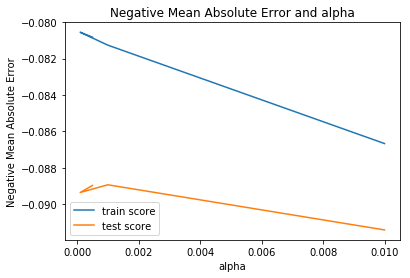

In [180]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='lower left')
plt.show()

In [181]:
# model with optimal alpha
# lasso regression
lasso = Lasso(alpha=0.001)
lasso.fit(X_train, y_train)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

#### Predict the values on train and test data and caluclate R2 score

In [182]:
# predict
y_train_pred = lasso.predict(X_train)
print(metrics.r2_score(y_true=y_train, y_pred=y_train_pred))
y_test_pred = lasso.predict(X_test)
print(metrics.r2_score(y_true=y_test, y_pred=y_test_pred))

0.9188832266910886
0.8865817325410336


In [183]:
print(rmsle(y_train_pred, y_train))
print(rmsle(y_test_pred, y_test))

0.113
0.136


In [184]:
# lasso model parameters
model_parameters = list(lasso.coef_)
model_parameters.insert(0, lasso.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = X.columns
cols = cols.insert(0, "constant")
list(zip(cols, model_parameters))

[('constant', 12.032),
 ('ExterQual', -0.002),
 ('ExterCond', 0.004),
 ('BsmtQual', -0.007),
 ('BsmtExposure', -0.013),
 ('HeatingQC', -0.01),
 ('CentralAir', 0.018),
 ('KitchenQual', -0.014),
 ('GarageQual', -0.002),
 ('GarageCond', 0.005),
 ('LotFrontage', 0.017),
 ('LotArea', 0.014),
 ('OverallQual', 0.09),
 ('YearBuilt', 0.003),
 ('YearRemodAdd', 0.035),
 ('MasVnrArea', 0.005),
 ('BsmtFinSF1', 0.037),
 ('BsmtUnfSF', -0.001),
 ('TotalBsmtSF', 0.03),
 ('1stFlrSF', 0.027),
 ('2ndFlrSF', 0.018),
 ('GrLivArea', 0.086),
 ('BsmtFullBath', 0.015),
 ('FullBath', 0.006),
 ('HalfBath', 0.005),
 ('BedroomAbvGr', -0.0),
 ('TotRmsAbvGrd', 0.013),
 ('Fireplaces', 0.02),
 ('GarageYrBlt', 0.0),
 ('GarageCars', 0.015),
 ('GarageArea', 0.015),
 ('WoodDeckSF', 0.009),
 ('OpenPorchSF', 0.011),
 ('EnclosedPorch', -0.0),
 ('ScreenPorch', 0.009),
 ('PoolArea', 0.005),
 ('RL', 0.013),
 ('RM', -0.0),
 ('IR2', 0.003),
 ('Reg', -0.006),
 ('HLS', 0.006),
 ('CulDSac', 0.011),
 ('BrDale', -0.006),
 ('BrkSide', -

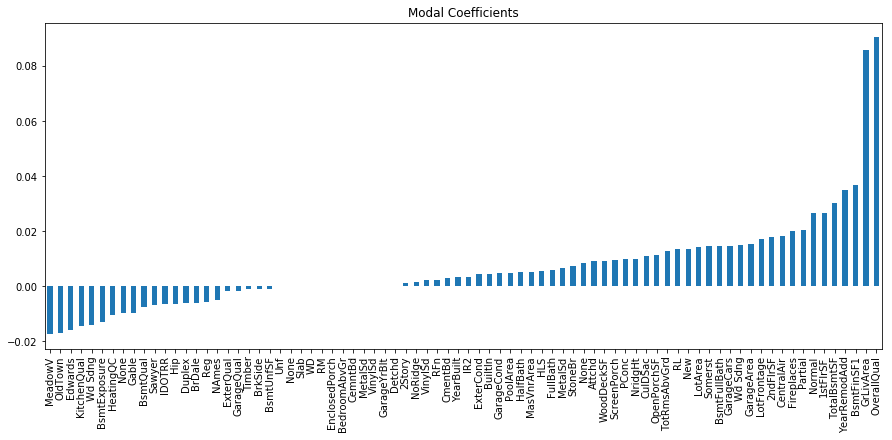

In [185]:
from pandas import Series, DataFrame

predictors = X.columns
plt.figure(figsize=[15,6])
coef = Series(lasso.coef_,predictors).sort_values()
coef.plot(kind='bar', title='Modal Coefficients')

 

### 5.2 Building a Ridge Model

In [194]:
# list of alphas to tune
params = {'alpha': [1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    0.4s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=1)

In [195]:
#copy the result in dataframe
cv_results = pd.DataFrame(model_cv.cv_results_)
#cv_results = cv_results[cv_results['param_alpha']<=200]
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.003480,0.002383,0.000225,0.000451,1,{'alpha': 1.0},-0.091339,-0.092678,-0.084908,-0.093373,...,-0.089366,0.003856,13,-0.079520,-0.079921,-0.082190,-0.079545,-0.081295,-0.080494,0.001067
1,0.003121,0.001735,0.001394,0.001447,2,{'alpha': 2.0},-0.091391,-0.092757,-0.084937,-0.093383,...,-0.089359,0.003923,12,-0.079549,-0.080003,-0.082212,-0.079596,-0.081365,-0.080545,0.001062
2,0.004692,0.002001,0.000702,0.000598,3,{'alpha': 3.0},-0.091427,-0.092806,-0.084930,-0.093377,...,-0.089338,0.003982,11,-0.079566,-0.080059,-0.082229,-0.079631,-0.081404,-0.080578,0.001058
3,0.004474,0.000990,0.000305,0.000402,4,{'alpha': 4.0},-0.091454,-0.092834,-0.084910,-0.093361,...,-0.089309,0.004033,10,-0.079577,-0.080104,-0.082244,-0.079659,-0.081436,-0.080604,0.001056
4,0.004059,0.002194,0.000309,0.000404,5,{'alpha': 5.0},-0.091476,-0.092849,-0.084886,-0.093336,...,-0.089278,0.004077,9,-0.079590,-0.080139,-0.082255,-0.079682,-0.081461,-0.080625,0.001054


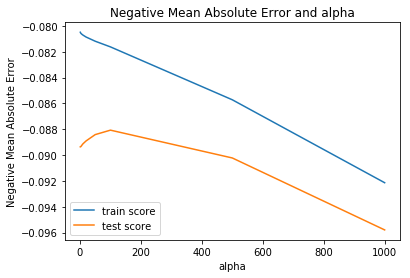

In [197]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='lower left')
plt.show()

In [203]:
# model with optimal alpha
# ridge regression
alpha = 20
ridge = Ridge(alpha=alpha)
ridge.fit(X_train, y_train)

Ridge(alpha=20, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

#### Predict the values on train and test data and caluclate R2 score

In [204]:
# predict
y_train_pred = ridge.predict(X_train)
print(metrics.r2_score(y_true=y_train, y_pred=y_train_pred))
y_test_pred = ridge.predict(X_test)
print(metrics.r2_score(y_true=y_test, y_pred=y_test_pred))

0.9201335539849339
0.8858413758942143


In [205]:
print(rmsle(y_train_pred, y_train))
print(rmsle(y_test_pred, y_test))

0.112
0.137


In [206]:
# ridge model parameters
model_parameters = list(ridge.coef_)
model_parameters.insert(0, ridge.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = X.columns
cols = cols.insert(0, "constant")
list(zip(cols, model_parameters))

[('constant', 12.032),
 ('ExterQual', -0.003),
 ('ExterCond', 0.005),
 ('BsmtQual', -0.006),
 ('BsmtExposure', -0.013),
 ('HeatingQC', -0.011),
 ('CentralAir', 0.019),
 ('KitchenQual', -0.015),
 ('GarageQual', -0.005),
 ('GarageCond', 0.008),
 ('LotFrontage', 0.018),
 ('LotArea', 0.015),
 ('OverallQual', 0.083),
 ('YearBuilt', 0.003),
 ('YearRemodAdd', 0.033),
 ('MasVnrArea', 0.008),
 ('BsmtFinSF1', 0.031),
 ('BsmtUnfSF', -0.009),
 ('TotalBsmtSF', 0.034),
 ('1stFlrSF', 0.05),
 ('2ndFlrSF', 0.04),
 ('GrLivArea', 0.053),
 ('BsmtFullBath', 0.015),
 ('FullBath', 0.008),
 ('HalfBath', 0.006),
 ('BedroomAbvGr', -0.001),
 ('TotRmsAbvGrd', 0.018),
 ('Fireplaces', 0.02),
 ('GarageYrBlt', -0.004),
 ('GarageCars', 0.014),
 ('GarageArea', 0.016),
 ('WoodDeckSF', 0.01),
 ('OpenPorchSF', 0.012),
 ('EnclosedPorch', 0.001),
 ('ScreenPorch', 0.011),
 ('PoolArea', 0.006),
 ('RL', 0.016),
 ('RM', 0.006),
 ('IR2', 0.004),
 ('Reg', -0.006),
 ('HLS', 0.007),
 ('CulDSac', 0.012),
 ('BrDale', -0.008),
 ('BrkS

##### Plotting the coefficient

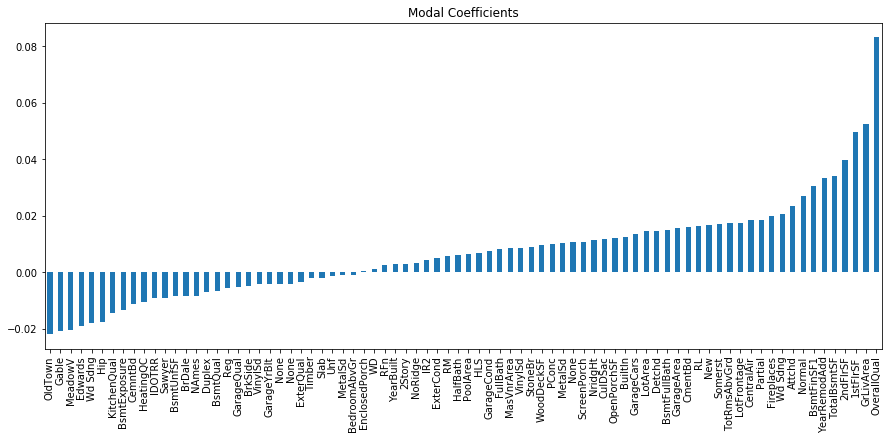

In [207]:
predictors = X.columns
plt.figure(figsize=[15,6])
coef = Series(ridge.coef_,predictors).sort_values()
coef.plot(kind='bar', title='Modal Coefficients')

# Inferences

1. Linear Regression

    R2 Score
    1. training- 92
    2. test - 89
    
    RMSLE
    1. training - 0.11
    2. test - 0.13
    
    From linear regression we can say that high value coeffiecients features having mostly effect on saleprice are 
        - LotArea
        - TotalBsmtSF
        - 1stFlrSF
        - Slab
        - YearBuilt
        - BsmtUnfSF
        and negative impact of
        - Fireplaces
        - Detchd
     
    
2. Lasso Regression
    R2 Score
    1. training - 92
    2. test - 89
    
    RMSLE
    1. training - 0.11
    2. test - 0.13
    
    top 10 coefficients having high value
        - OverallQual
        - GrLivArea
        - BsmtFinSF1
        - YearRemodAdd
        - TotalBsmtSF
        - 1stFlrSF
        - Normal
        - Partial
        - Fireplaces
        - CentralAir
2. Ridge Regression
    R2 Score
    1. training - 92
    2. test - 88
    
    RMSLE
    1. training - 0.11
    2. test - 0.13
   
   top 10 coefficients having high value
       - OverallQual
       - GrLivArea
       -  1stFlrSF
        - 2ndFlrSF
        - TotalBsmtSF
        - YearRemodAdd
        - BsmtFinSF1
        - Normal
        - Attchd
        - Wd Sdng  

From all the models Lasso perfomrs well as R2 on test data is higher then Ridge also higher values of coefficients by making applying feature selection.
